In [1]:
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error


/opt/homebrew/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
data  = pd.read_pickle('../Data/sales_day.pkl')
data['date'] = pd.to_datetime(data['date'])
data.columns = ['ds', 'y']

In [3]:
# remove outliers
data = data[data['y'] < data['y'].quantile(0.95)]

In [4]:
# train test split
training_x = data.iloc[:int(len(data)*0.8)]
val_x = data.iloc[int(len(data)*0.8):int(len(data)*0.9)].reset_index(drop=True)
testing_x = data.iloc[int(len(data)*0.9):].reset_index(drop=True)

In [5]:
print(len(training_x))
print(len(val_x))
print(len(testing_x))

458
57
58


In [6]:
m = Prophet(growth='linear', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative',
            changepoint_prior_scale=0.2,seasonality_prior_scale=5, holidays_prior_scale=5, 
            changepoint_range=0.5, interval_width=0.95, uncertainty_samples=1000)
m.add_country_holidays(country_name='UK')
m.fit(training_x)

Initial log joint probability = -15.0984


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81        720.14   0.000413076       22.4192   2.159e-05       0.001      151  LS failed, Hessian reset 
      99       720.148   8.01843e-06       16.4895      0.3948      0.3948      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.255   2.68121e-06       17.5477      0.3007      0.4955      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.278   0.000101979       16.4681           1           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       720.285   8.90032e-05       21.3818           1           1      544   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     406       720.285    2.9678e-06       15.6432       0.229           1      5

In [7]:
future = val_x[['ds']]
future.tail()


,ds
52,2011-09-14
53,2011-09-16
54,2011-09-18
55,2011-09-19
56,2011-09-21


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
52,2011-09-14,19530.251464,7124.257789,31151.349609
53,2011-09-16,19030.347284,7655.299166,31379.932414
54,2011-09-18,17047.961503,4311.080584,28961.797856
55,2011-09-19,24106.942937,11349.702010,36533.664228
56,2011-09-21,25074.510250,13779.012531,37833.910603


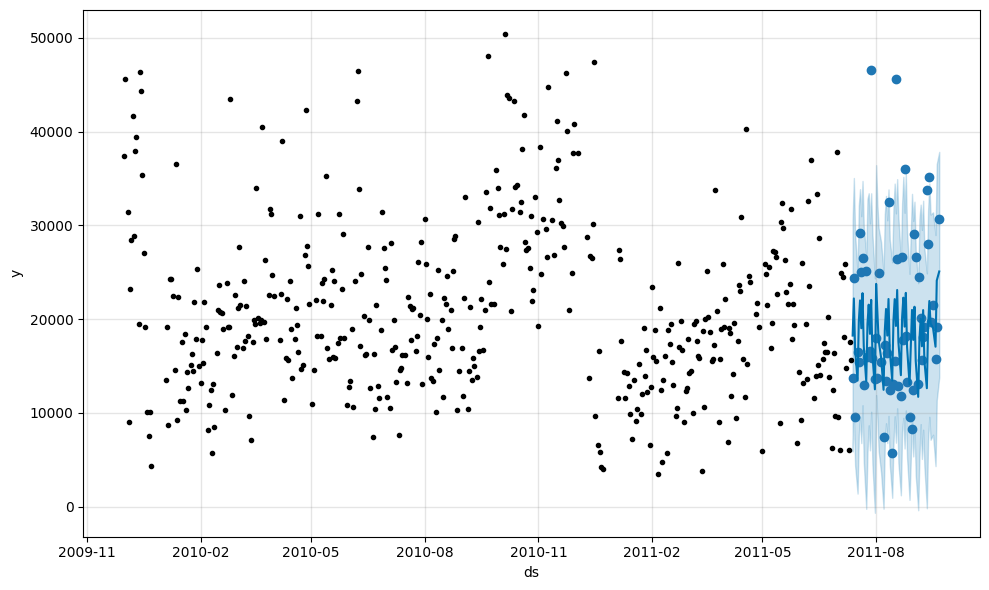

In [9]:
fig1 = m.plot(forecast)
plt.scatter(val_x['ds'], val_x['y'])

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


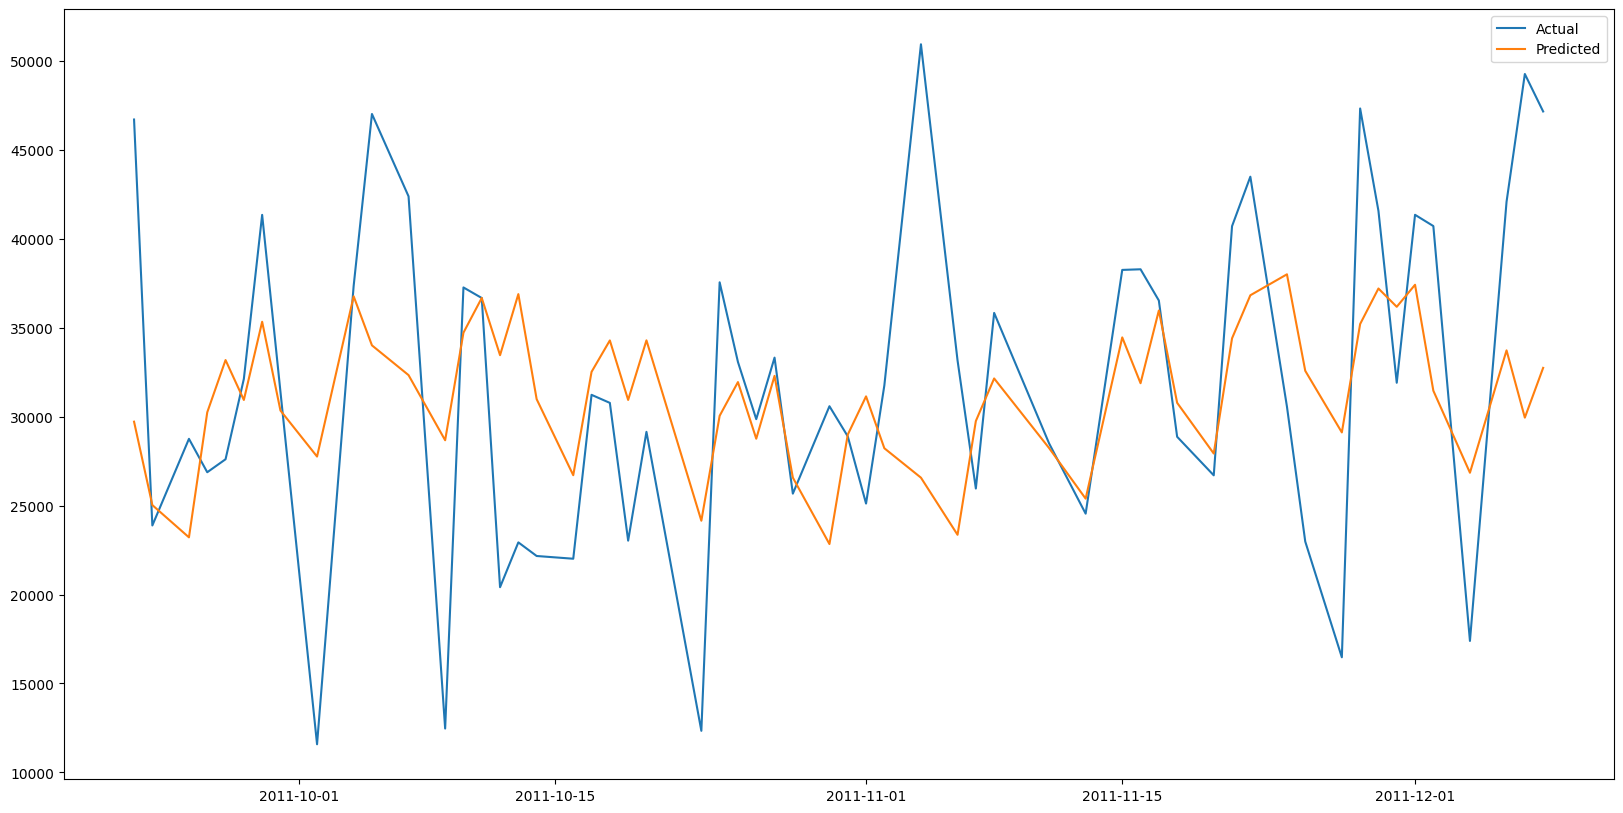

In [10]:
forecast = m.predict(testing_x[['ds']])
plt.figure(figsize=(20,10))
plt.plot(testing_x['ds'], testing_x['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted')
plt.legend()
plt.show()

In [11]:
print("MAPE: ", mean_absolute_percentage_error(testing_x['y'], forecast['yhat']))

MAPE:  0.24704364899050854


In [12]:
def GridProphet(change_prior_scale, seasonality_prior_scale, holidays_prior_scale,changepoint_range, interval_width, uncertainty_samples):
    m = Prophet(growth='linear', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative',
                changepoint_prior_scale=change_prior_scale, seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale,
                changepoint_range=changepoint_range, interval_width=interval_width, uncertainty_samples=uncertainty_samples)
    m.add_country_holidays(country_name='UK')
    m.fit(training_x,verbose=False)
    future = val_x[['ds']]
    forecast = m.predict(future)
    mape = mean_absolute_percentage_error(val_x['y'], forecast['yhat'])
    return mape

In [13]:
from sklearn.model_selection import ParameterGrid
param = {
    'change_prior_scale': [0.05,0.1,0.15], 'seasonality_prior_scale': [4,5,6], 'holidays_prior_scale': [5.5,6,6.5],
    'changepoint_range': [0.6,0.7,0.8], 'interval_width': [0.7,0.75,0.8], 'uncertainty_samples': [100,125,250]
         }
param_grid = ParameterGrid(param)

In [14]:
mape = 1
best_param = {}
for p in tqdm(param_grid):
    result = GridProphet(p['change_prior_scale'],p['seasonality_prior_scale'],p['holidays_prior_scale'], p['changepoint_range'], p['interval_width'], p['uncertainty_samples'])
    if result < mape:
        mape = result
        best_param = p
    

  0%|          | 0/729 [00:00<?, ?it/s]

Initial log joint probability = -15.0984


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  0%|          | 1/729 [00:00<01:52,  6.46it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       718.582    0.00162053        109.33   1.762e-05       0.001      151  LS failed, Hessian reset 
      99       718.735   0.000185629       90.2248      0.7984      0.7984      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.314   4.93181e-06       93.7703           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       719.345   7.66802e-08       77.7238      0.2369           1      418   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       718.582    0.00162053        109.33   1.762e-05       0.001      151  LS failed, Hessian reset 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  0%|          | 2/729 [00:00<01:49,  6.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       718.582    0.00162053        109.33   1.762e-05       0.001      151  LS failed, Hessian reset 
      99       718.735   0.000185629       90.2248      0.7984      0.7984      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.314   4.93181e-06       93.7703           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       719.345   7.66802e-08       77.7238      0.2369           1      418   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.774   0.000639144       92.6146           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  1%|          | 4/729 [00:00<01:52,  6.43it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.774   0.000639144       92.6146           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.32   1.14038e-06       109.078       3.227      0.3227      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207        719.32   4.53245e-06       113.971   4.701e-08       0.001      313  LS failed, Hessian reset 
     230       719.321   4.06124e-08       82.7818      0.1695      0.9884      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.774   0.000639144       92.6146           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  1%|          | 6/729 [00:00<01:55,  6.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.106    0.00513709       104.734           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.214   0.000532761       98.5588   5.255e-06       0.001      194  LS failed, Hessian reset 
     158       719.269   3.09781e-08       86.9203       0.158           1      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.106    0.00513709       104.734           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.214   0.000532761       98.5588   5.255e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  1%|          | 9/729 [00:01<01:49,  6.56it/s]

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.106    0.00513709       104.734           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.214   0.000532761       98.5588   5.255e-06       0.001      194  LS failed, Hessian reset 
     158       719.269   3.09781e-08       86.9203       0.158           1      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  1%|▏         | 10/729 [00:01<01:57,  6.11it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       718.582    0.00162053        109.33   1.762e-05       0.001      151  LS failed, Hessian reset 
      99       718.735   0.000185629       90.2248      0.7984      0.7984      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.314   4.93181e-06       93.7703           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       719.345   7.66802e-08       77.7238      0.2369           1      418   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       718.582    0.00162053        109.33   1.762e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 11/729 [00:01<01:54,  6.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       718.582    0.00162053        109.33   1.762e-05       0.001      151  LS failed, Hessian reset 
      99       718.735   0.000185629       90.2248      0.7984      0.7984      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.314   4.93181e-06       93.7703           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       719.345   7.66802e-08       77.7238      0.2369           1      418   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.774   0.000639144       92.6146           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 13/729 [00:02<01:53,  6.32it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.774   0.000639144       92.6146           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.32   1.14038e-06       109.078       3.227      0.3227      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207        719.32   4.53245e-06       113.971   4.701e-08       0.001      313  LS failed, Hessian reset 
     230       719.321   4.06124e-08       82.7818      0.1695      0.9884      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.774   0.000639144       92.6146           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 15/729 [00:02<01:55,  6.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.106    0.00513709       104.734           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.214   0.000532761       98.5588   5.255e-06       0.001      194  LS failed, Hessian reset 
     158       719.269   3.09781e-08       86.9203       0.158           1      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.106    0.00513709       104.734           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.214   0.000532761       98.5588   5.255e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 18/729 [00:02<01:47,  6.60it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.106    0.00513709       104.734           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.214   0.000532761       98.5588   5.255e-06       0.001      194  LS failed, Hessian reset 
     158       719.269   3.09781e-08       86.9203       0.158           1      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       718.582    0.00162053        109.33   1.762e-05       0.001      151  LS failed, Hessian reset 
      99       718.735   0.000185629       90.2248      0.7984      0.7984      170   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  3%|▎         | 19/729 [00:02<01:46,  6.68it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       718.582    0.00162053        109.33   1.762e-05       0.001      151  LS failed, Hessian reset 
      99       718.735   0.000185629       90.2248      0.7984      0.7984      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.314   4.93181e-06       93.7703           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       719.345   7.66802e-08       77.7238      0.2369           1      418   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       718.582    0.00162053        109.33   1.762e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  3%|▎         | 21/729 [00:03<01:55,  6.13it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.774   0.000639144       92.6146           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.32   1.14038e-06       109.078       3.227      0.3227      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207        719.32   4.53245e-06       113.971   4.701e-08       0.001      313  LS failed, Hessian reset 
     230       719.321   4.06124e-08       82.7818      0.1695      0.9884      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.774   0.000639144       92.6146           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  3%|▎         | 24/729 [00:03<01:53,  6.20it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.774   0.000639144       92.6146           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.32   1.14038e-06       109.078       3.227      0.3227      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207        719.32   4.53245e-06       113.971   4.701e-08       0.001      313  LS failed, Hessian reset 
     230       719.321   4.06124e-08       82.7818      0.1695      0.9884      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.106    0.00513709       104.734           1          

  3%|▎         | 25/729 [00:03<01:44,  6.72it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  4%|▎         | 26/729 [00:03<01:40,  6.99it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.106    0.00513709       104.734           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.214   0.000532761       98.5588   5.255e-06       0.001      194  LS failed, Hessian reset 
     158       719.269   3.09781e-08       86.9203       0.158           1      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.106    0.00513709       104.734           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.214   0.000532761       98.5588   5.255e-06       0.0

  4%|▎         | 27/729 [00:04<01:46,  6.59it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  4%|▍         | 28/729 [00:04<01:45,  6.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       718.575     0.0020139       108.835   2.508e-05       0.001      132  LS failed, Hessian reset 
      99       718.745   2.81907e-05       83.6929      0.4505      0.4505      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.133    0.00304911       102.914   3.041e-05       0.001      235  LS failed, Hessian reset 
     199       719.336   1.29189e-06       90.2653           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.366   3.88264e-07       98.8085      0.2855       0.934      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       719.367   3.29355e-08       86.5216      0.3597      0.9163      447   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  4%|▍         | 29/729 [00:04<01:46,  6.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       718.575     0.0020139       108.835   2.508e-05       0.001      132  LS failed, Hessian reset 
      99       718.745   2.81907e-05       83.6929      0.4505      0.4505      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.133    0.00304911       102.914   3.041e-05       0.001      235  LS failed, Hessian reset 
     199       719.336   1.29189e-06       90.2653           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.366   3.88264e-07       98.8085      0.2855       0.934      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       719.367   3.29355e-08       86.5216      0.3597      0.9163      447   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  4%|▍         | 31/729 [00:04<01:46,  6.53it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.815    0.00010047       79.3538       0.333           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.094    0.00165418       106.409   2.013e-05       0.001      198  LS failed, Hessian reset 
     195       719.226   3.68891e-08       96.6999      0.3397           1      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.815    0.00010047       79.3538       0.333           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.094    0.00165418       106.409   2.013e-05       0.0

  5%|▍         | 33/729 [00:05<01:50,  6.30it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▍         | 34/729 [00:05<01:46,  6.53it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.986   0.000248094       75.0978      0.9373      0.9373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.201   0.000503491       102.542   5.134e-06       0.001      197  LS failed, Hessian reset 
     194       719.297   9.37389e-06       89.0249   9.258e-08       0.001      324  LS failed, Hessian reset 
     199       719.298     2.616e-06       93.0445      0.4089      0.9995      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       719.298   6.06454e-08       86.9553       0.968       0.968      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

  5%|▍         | 35/729 [00:05<01:45,  6.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▍         | 36/729 [00:05<01:59,  5.80it/s]

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.986   0.000248094       75.0978      0.9373      0.9373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.201   0.000503491       102.542   5.134e-06       0.001      197  LS failed, Hessian reset 
     194       719.297   9.37389e-06       89.0249   9.258e-08       0.001      324  LS failed, Hessian reset 
     199       719.298     2.616e-06       93.0445      0.4089      0.9995      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       719.298   6.06454e-08       86.9553       0.968       0.968      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▌         | 37/729 [00:05<01:54,  6.05it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       718.575     0.0020139       108.835   2.508e-05       0.001      132  LS failed, Hessian reset 
      99       718.745   2.81907e-05       83.6929      0.4505      0.4505      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.133    0.00304911       102.914   3.041e-05       0.001      235  LS failed, Hessian reset 
     199       719.336   1.29189e-06       90.2653           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.366   3.88264e-07       98.8085      0.2855       0.934      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       719.367   3.29355e-08       86.5216      0.3597      0.9163      447   
Optimization terminated normally: 
  Convergence detected: rel

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▌         | 38/729 [00:05<01:52,  6.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       718.575     0.0020139       108.835   2.508e-05       0.001      132  LS failed, Hessian reset 
      99       718.745   2.81907e-05       83.6929      0.4505      0.4505      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.133    0.00304911       102.914   3.041e-05       0.001      235  LS failed, Hessian reset 
     199       719.336   1.29189e-06       90.2653           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.366   3.88264e-07       98.8085      0.2855       0.934      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       719.367   3.29355e-08       86.5216      0.3597      0.9163      447   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▌         | 40/729 [00:06<01:49,  6.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.815    0.00010047       79.3538       0.333           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.094    0.00165418       106.409   2.013e-05       0.001      198  LS failed, Hessian reset 
     195       719.226   3.68891e-08       96.6999      0.3397           1      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.815    0.00010047       79.3538       0.333           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.094    0.00165418       106.409   2.013e-05       0.0

  6%|▌         | 42/729 [00:06<01:49,  6.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▌         | 43/729 [00:06<01:45,  6.49it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.986   0.000248094       75.0978      0.9373      0.9373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.201   0.000503491       102.542   5.134e-06       0.001      197  LS failed, Hessian reset 
     194       719.297   9.37389e-06       89.0249   9.258e-08       0.001      324  LS failed, Hessian reset 
     199       719.298     2.616e-06       93.0445      0.4089      0.9995      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       719.298   6.06454e-08       86.9553       0.968       0.968      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▌         | 44/729 [00:06<01:45,  6.48it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.986   0.000248094       75.0978      0.9373      0.9373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.201   0.000503491       102.542   5.134e-06       0.001      197  LS failed, Hessian reset 
     194       719.297   9.37389e-06       89.0249   9.258e-08       0.001      324  LS failed, Hessian reset 
     199       719.298     2.616e-06       93.0445      0.4089      0.9995      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       719.298   6.06454e-08       86.9553       0.968       0.968      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▋         | 46/729 [00:07<01:51,  6.13it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       718.575     0.0020139       108.835   2.508e-05       0.001      132  LS failed, Hessian reset 
      99       718.745   2.81907e-05       83.6929      0.4505      0.4505      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.133    0.00304911       102.914   3.041e-05       0.001      235  LS failed, Hessian reset 
     199       719.336   1.29189e-06       90.2653           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.366   3.88264e-07       98.8085      0.2855       0.934      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       719.367   3.29355e-08       86.5216      0.3597      0.9163      447   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  7%|▋         | 48/729 [00:07<01:57,  5.77it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.815    0.00010047       79.3538       0.333           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.094    0.00165418       106.409   2.013e-05       0.001      198  LS failed, Hessian reset 
     195       719.226   3.68891e-08       96.6999      0.3397           1      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.815    0.00010047       79.3538       0.333           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.094    0.00165418       106.409   2.013e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  7%|▋         | 51/729 [00:07<01:47,  6.30it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.815    0.00010047       79.3538       0.333           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.094    0.00165418       106.409   2.013e-05       0.001      198  LS failed, Hessian reset 
     195       719.226   3.68891e-08       96.6999      0.3397           1      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.986   0.000248094       75.0978      0.9373      0.9373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.201   0.000503491       102.542   5.134e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  7%|▋         | 52/729 [00:08<01:44,  6.50it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.986   0.000248094       75.0978      0.9373      0.9373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.201   0.000503491       102.542   5.134e-06       0.001      197  LS failed, Hessian reset 
     194       719.297   9.37389e-06       89.0249   9.258e-08       0.001      324  LS failed, Hessian reset 
     199       719.298     2.616e-06       93.0445      0.4089      0.9995      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       719.298   6.06454e-08       86.9553       0.968       0.968      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  7%|▋         | 54/729 [00:08<01:50,  6.12it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       718.625    0.00142631       94.7395    1.54e-05       0.001      142  LS failed, Hessian reset 
      99       718.687   5.85555e-05       80.7231      0.2648      0.2648      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       719.146    0.00120337       96.0386   1.093e-05       0.001      277  LS failed, Hessian reset 
     199       719.328   2.53946e-06       103.043      0.5087      0.5087      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.352   4.60309e-06       103.292           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       719.353   2.01249e-08       92.7856      0.2891           1      472   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  8%|▊         | 56/729 [00:08<01:46,  6.30it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       718.625    0.00142631       94.7395    1.54e-05       0.001      142  LS failed, Hessian reset 
      99       718.687   5.85555e-05       80.7231      0.2648      0.2648      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       719.146    0.00120337       96.0386   1.093e-05       0.001      277  LS failed, Hessian reset 
     199       719.328   2.53946e-06       103.043      0.5087      0.5087      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.352   4.60309e-06       103.292           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       719.353   2.01249e-08       92.7856      0.2891           1      472   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  8%|▊         | 58/729 [00:09<01:45,  6.35it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.111    0.00294209       99.3417      0.5051           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.129   7.32119e-05       98.5691   8.577e-07       0.001      169  LS failed, Hessian reset 
     199       719.268    3.5994e-08       93.1788       0.361       0.361      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.268   1.08454e-08       94.7673      0.3052           1      301   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.111    0.00294209       99.3417      0.5051          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  8%|▊         | 60/729 [00:09<01:46,  6.28it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.025   0.000336661        83.948      0.4699      0.4699      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.187   0.000508714       100.104    5.31e-06       0.001      206  LS failed, Hessian reset 
     172       719.282    3.1538e-08       106.503           1           1      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.025   0.000336661        83.948      0.4699      0.4699      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.187   0.000508714       100.104    5.31e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▊         | 63/729 [00:09<01:49,  6.09it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.025   0.000336661        83.948      0.4699      0.4699      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.187   0.000508714       100.104    5.31e-06       0.001      206  LS failed, Hessian reset 
     172       719.282    3.1538e-08       106.503           1           1      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▉         | 64/729 [00:10<01:47,  6.16it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       718.625    0.00142631       94.7395    1.54e-05       0.001      142  LS failed, Hessian reset 
      99       718.687   5.85555e-05       80.7231      0.2648      0.2648      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       719.146    0.00120337       96.0386   1.093e-05       0.001      277  LS failed, Hessian reset 
     199       719.328   2.53946e-06       103.043      0.5087      0.5087      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.352   4.60309e-06       103.292           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       719.353   2.01249e-08       92.7856      0.2891           1      472   
Optimization terminated normally: 
  Convergence detected: rel

  9%|▉         | 65/729 [00:10<01:47,  6.18it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▉         | 66/729 [00:10<01:54,  5.77it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       718.625    0.00142631       94.7395    1.54e-05       0.001      142  LS failed, Hessian reset 
      99       718.687   5.85555e-05       80.7231      0.2648      0.2648      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       719.146    0.00120337       96.0386   1.093e-05       0.001      277  LS failed, Hessian reset 
     199       719.328   2.53946e-06       103.043      0.5087      0.5087      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.352   4.60309e-06       103.292           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       719.353   2.01249e-08       92.7856      0.2891           1      472   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▉         | 67/729 [00:10<01:45,  6.28it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.111    0.00294209       99.3417      0.5051           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.129   7.32119e-05       98.5691   8.577e-07       0.001      169  LS failed, Hessian reset 
     199       719.268    3.5994e-08       93.1788       0.361       0.361      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.268   1.08454e-08       94.7673      0.3052           1      301   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.111    0.00294209       99.3417      0.5051          

  9%|▉         | 69/729 [00:10<01:44,  6.29it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 10%|▉         | 70/729 [00:10<01:37,  6.73it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.025   0.000336661        83.948      0.4699      0.4699      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.187   0.000508714       100.104    5.31e-06       0.001      206  LS failed, Hessian reset 
     172       719.282    3.1538e-08       106.503           1           1      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.025   0.000336661        83.948      0.4699      0.4699      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.187   0.000508714       100.104    5.31e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 10%|▉         | 72/729 [00:11<01:40,  6.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.025   0.000336661        83.948      0.4699      0.4699      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.187   0.000508714       100.104    5.31e-06       0.001      206  LS failed, Hessian reset 
     172       719.282    3.1538e-08       106.503           1           1      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       718.625    0.00142631       94.7395    1.54e-05       0.001      142  LS failed, Hessian reset 
      99       718.687   5.85555e-05       80.7231      0.2648      0.2648      154   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 10%|█         | 73/729 [00:11<01:39,  6.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       718.625    0.00142631       94.7395    1.54e-05       0.001      142  LS failed, Hessian reset 
      99       718.687   5.85555e-05       80.7231      0.2648      0.2648      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       719.146    0.00120337       96.0386   1.093e-05       0.001      277  LS failed, Hessian reset 
     199       719.328   2.53946e-06       103.043      0.5087      0.5087      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.352   4.60309e-06       103.292           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       719.353   2.01249e-08       92.7856      0.2891           1      472   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 10%|█         | 75/729 [00:11<01:49,  5.99it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.111    0.00294209       99.3417      0.5051           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.129   7.32119e-05       98.5691   8.577e-07       0.001      169  LS failed, Hessian reset 
     199       719.268    3.5994e-08       93.1788       0.361       0.361      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.268   1.08454e-08       94.7673      0.3052           1      301   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.111    0.00294209       99.3417      0.5051          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 11%|█         | 78/729 [00:12<01:42,  6.34it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.111    0.00294209       99.3417      0.5051           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.129   7.32119e-05       98.5691   8.577e-07       0.001      169  LS failed, Hessian reset 
     199       719.268    3.5994e-08       93.1788       0.361       0.361      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.268   1.08454e-08       94.7673      0.3052           1      301   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.025   0.000336661        83.948      0.4699      0.46

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 11%|█         | 79/729 [00:12<01:35,  6.79it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.025   0.000336661        83.948      0.4699      0.4699      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.187   0.000508714       100.104    5.31e-06       0.001      206  LS failed, Hessian reset 
     172       719.282    3.1538e-08       106.503           1           1      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.025   0.000336661        83.948      0.4699      0.4699      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.187   0.000508714       100.104    5.31e-06       0.0

 11%|█         | 81/729 [00:12<01:38,  6.59it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 11%|█         | 82/729 [00:12<01:33,  6.91it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.154   0.000619964       106.429           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       719.249   5.56283e-05       100.093   5.225e-07       0.001      194  LS failed, Hessian reset 
     199       719.254   5.51609e-07        103.01      0.9462      0.9462      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       719.254   2.61214e-08       102.457      0.3185           1      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.154   0.000619964       106.429           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 84/729 [00:13<01:37,  6.62it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.154   0.000619964       106.429           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       719.249   5.56283e-05       100.093   5.225e-07       0.001      194  LS failed, Hessian reset 
     199       719.254   5.51609e-07        103.01      0.9462      0.9462      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       719.254   2.61214e-08       102.457      0.3185           1      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.068   9.35993e-06       83.6556      0.6933      0.69

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 85/729 [00:13<01:36,  6.70it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.068   9.35993e-06       83.6556      0.6933      0.6933      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       719.083   0.000266468       107.927   3.134e-06       0.001      209  LS failed, Hessian reset 
     199       719.113   0.000190966       81.8284      0.6196      0.6196      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       719.138   8.94442e-05        99.215   9.162e-07       0.001      342  LS failed, Hessian reset 
     262       719.161    4.2823e-09       74.2943      0.1329      0.1329      409   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 87/729 [00:13<01:44,  6.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.204   3.67246e-05       72.1365      0.3679           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.22   9.65947e-05       74.2186   9.728e-07       0.001      194  LS failed, Hessian reset 
     199       719.226   3.37908e-06       81.8147           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.334   5.38569e-06       86.4697       0.233           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       719.334   4.10826e-08       90.0868           1           1      459   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 89/729 [00:13<01:40,  6.37it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.204   3.67246e-05       72.1365      0.3679           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.22   9.65947e-05       74.2186   9.728e-07       0.001      194  LS failed, Hessian reset 
     199       719.226   3.37908e-06       81.8147           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.334   5.38569e-06       86.4697       0.233           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       719.334   4.10826e-08       90.0868           1           1      459   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 91/729 [00:14<01:39,  6.43it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.154   0.000619964       106.429           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       719.249   5.56283e-05       100.093   5.225e-07       0.001      194  LS failed, Hessian reset 
     199       719.254   5.51609e-07        103.01      0.9462      0.9462      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       719.254   2.61214e-08       102.457      0.3185           1      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.154   0.000619964       106.429           1          

 13%|█▎        | 93/729 [00:14<01:39,  6.41it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 13%|█▎        | 94/729 [00:14<01:36,  6.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.068   9.35993e-06       83.6556      0.6933      0.6933      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       719.083   0.000266468       107.927   3.134e-06       0.001      209  LS failed, Hessian reset 
     199       719.113   0.000190966       81.8284      0.6196      0.6196      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       719.138   8.94442e-05        99.215   9.162e-07       0.001      342  LS failed, Hessian reset 
     262       719.161    4.2823e-09       74.2943      0.1329      0.1329      409   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||    

 13%|█▎        | 95/729 [00:14<01:35,  6.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 13%|█▎        | 96/729 [00:15<01:48,  5.81it/s]

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.068   9.35993e-06       83.6556      0.6933      0.6933      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       719.083   0.000266468       107.927   3.134e-06       0.001      209  LS failed, Hessian reset 
     199       719.113   0.000190966       81.8284      0.6196      0.6196      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       719.138   8.94442e-05        99.215   9.162e-07       0.001      342  LS failed, Hessian reset 
     262       719.161    4.2823e-09       74.2943      0.1329      0.1329      409   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 13%|█▎        | 97/729 [00:15<01:45,  6.02it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.204   3.67246e-05       72.1365      0.3679           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.22   9.65947e-05       74.2186   9.728e-07       0.001      194  LS failed, Hessian reset 
     199       719.226   3.37908e-06       81.8147           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.334   5.38569e-06       86.4697       0.233           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       719.334   4.10826e-08       90.0868           1           1      459   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 13%|█▎        | 98/729 [00:15<01:43,  6.12it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.204   3.67246e-05       72.1365      0.3679           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.22   9.65947e-05       74.2186   9.728e-07       0.001      194  LS failed, Hessian reset 
     199       719.226   3.37908e-06       81.8147           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.334   5.38569e-06       86.4697       0.233           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       719.334   4.10826e-08       90.0868           1           1      459   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 14%|█▎        | 100/729 [00:15<01:39,  6.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.154   0.000619964       106.429           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       719.249   5.56283e-05       100.093   5.225e-07       0.001      194  LS failed, Hessian reset 
     199       719.254   5.51609e-07        103.01      0.9462      0.9462      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       719.254   2.61214e-08       102.457      0.3185           1      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.154   0.000619964       106.429           1          

 14%|█▍        | 102/729 [00:15<01:40,  6.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 14%|█▍        | 103/729 [00:16<01:39,  6.28it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.068   9.35993e-06       83.6556      0.6933      0.6933      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       719.083   0.000266468       107.927   3.134e-06       0.001      209  LS failed, Hessian reset 
     199       719.113   0.000190966       81.8284      0.6196      0.6196      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       719.138   8.94442e-05        99.215   9.162e-07       0.001      342  LS failed, Hessian reset 
     262       719.161    4.2823e-09       74.2943      0.1329      0.1329      409   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 14%|█▍        | 104/729 [00:16<01:39,  6.29it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.068   9.35993e-06       83.6556      0.6933      0.6933      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       719.083   0.000266468       107.927   3.134e-06       0.001      209  LS failed, Hessian reset 
     199       719.113   0.000190966       81.8284      0.6196      0.6196      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       719.138   8.94442e-05        99.215   9.162e-07       0.001      342  LS failed, Hessian reset 
     262       719.161    4.2823e-09       74.2943      0.1329      0.1329      409   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 15%|█▍        | 106/729 [00:16<01:43,  6.03it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.204   3.67246e-05       72.1365      0.3679           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.22   9.65947e-05       74.2186   9.728e-07       0.001      194  LS failed, Hessian reset 
     199       719.226   3.37908e-06       81.8147           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.334   5.38569e-06       86.4697       0.233           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       719.334   4.10826e-08       90.0868           1           1      459   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 15%|█▍        | 108/729 [00:17<01:51,  5.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        719.24   0.000368993       93.4686   3.966e-06       0.001      180  LS failed, Hessian reset 
     179       719.274    9.9147e-07       91.0439   1.119e-08       0.001      287  LS failed, Hessian reset 
     193       719.274   2.65144e-08       79.0487           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 15%|█▌        | 111/729 [00:17<01:41,  6.06it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        719.24   0.000368993       93.4686   3.966e-06       0.001      180  LS failed, Hessian reset 
     179       719.274    9.9147e-07       91.0439   1.119e-08       0.001      287  LS failed, Hessian reset 
     193       719.274   2.65144e-08       79.0487           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 15%|█▌        | 112/729 [00:17<01:36,  6.39it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.129   0.000156855       90.8835   1.554e-06       0.001      192  LS failed, Hessian reset 
     174       719.141   1.03943e-06        79.482   1.228e-08       0.001      309  LS failed, Hessian reset 
     192       719.141   7.44667e-09       75.4278      0.1925      0.1925      333   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 16%|█▌        | 114/729 [00:17<01:40,  6.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.001      162  LS failed, Hessian reset 
     166       719.231   2.82399e-08       90.0731      0.4786           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 16%|█▌        | 117/729 [00:18<01:31,  6.66it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.001      162  LS failed, Hessian reset 
     166       719.231   2.82399e-08       90.0731      0.4786           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        719.24   0.000368993       93.4686   3.966e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 16%|█▌        | 118/729 [00:18<01:27,  6.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        719.24   0.000368993       93.4686   3.966e-06       0.001      180  LS failed, Hessian reset 
     179       719.274    9.9147e-07       91.0439   1.119e-08       0.001      287  LS failed, Hessian reset 
     193       719.274   2.65144e-08       79.0487           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 16%|█▋        | 120/729 [00:18<01:33,  6.54it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.129   0.000156855       90.8835   1.554e-06       0.001      192  LS failed, Hessian reset 
     174       719.141   1.03943e-06        79.482   1.228e-08       0.001      309  LS failed, Hessian reset 
     192       719.141   7.44667e-09       75.4278      0.1925      0.1925      333   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 17%|█▋        | 123/729 [00:19<01:33,  6.45it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.129   0.000156855       90.8835   1.554e-06       0.001      192  LS failed, Hessian reset 
     174       719.141   1.03943e-06        79.482   1.228e-08       0.001      309  LS failed, Hessian reset 
     192       719.141   7.44667e-09       75.4278      0.1925      0.1925      333   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 17%|█▋        | 124/729 [00:19<01:26,  6.98it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.001      162  LS failed, Hessian reset 
     166       719.231   2.82399e-08       90.0731      0.4786           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.0

 17%|█▋        | 126/729 [00:19<01:35,  6.30it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 17%|█▋        | 127/729 [00:19<01:28,  6.77it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        719.24   0.000368993       93.4686   3.966e-06       0.001      180  LS failed, Hessian reset 
     179       719.274    9.9147e-07       91.0439   1.119e-08       0.001      287  LS failed, Hessian reset 
     193       719.274   2.65144e-08       79.0487           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 18%|█▊        | 129/729 [00:20<01:32,  6.50it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        719.24   0.000368993       93.4686   3.966e-06       0.001      180  LS failed, Hessian reset 
     179       719.274    9.9147e-07       91.0439   1.119e-08       0.001      287  LS failed, Hessian reset 
     193       719.274   2.65144e-08       79.0487           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 18%|█▊        | 130/729 [00:20<01:28,  6.80it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.129   0.000156855       90.8835   1.554e-06       0.001      192  LS failed, Hessian reset 
     174       719.141   1.03943e-06        79.482   1.228e-08       0.001      309  LS failed, Hessian reset 
     192       719.141   7.44667e-09       75.4278      0.1925      0.1925      333   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 18%|█▊        | 132/729 [00:20<01:32,  6.44it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.001      162  LS failed, Hessian reset 
     166       719.231   2.82399e-08       90.0731      0.4786           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▊        | 135/729 [00:20<01:26,  6.85it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.001      162  LS failed, Hessian reset 
     166       719.231   2.82399e-08       90.0731      0.4786           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.183    0.00143805       97.0142           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        719.23   0.000222029       101.536   2.468e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▊        | 136/729 [00:21<01:22,  7.18it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.183    0.00143805       97.0142           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        719.23   0.000222029       101.536   2.468e-06       0.001      185  LS failed, Hessian reset 
     193       719.273   1.97202e-08       82.3566       0.512       0.512      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.183    0.00143805       97.0142           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        719.23   0.000222029       101.536   2.468e-06       0.0

 19%|█▉        | 138/729 [00:21<01:28,  6.70it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▉        | 139/729 [00:21<01:28,  6.67it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.079   0.000570854       71.7893       0.352           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.131   0.000163765       83.6485   1.705e-06       0.001      188  LS failed, Hessian reset 
     199       719.146   1.01839e-06       69.4175      0.6721      0.6721      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        719.21    3.3422e-06       90.9101           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       719.221   3.29988e-08       93.2121      0.9198      0.9198      482   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▉        | 140/729 [00:21<01:29,  6.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.079   0.000570854       71.7893       0.352           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.131   0.000163765       83.6485   1.705e-06       0.001      188  LS failed, Hessian reset 
     199       719.146   1.01839e-06       69.4175      0.6721      0.6721      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        719.21    3.3422e-06       90.9101           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       719.221   3.29988e-08       93.2121      0.9198      0.9198      482   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▉        | 142/729 [00:22<01:29,  6.58it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.197   3.12746e-05       73.7574      0.4283      0.4283      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       719.221    0.00014388       93.4482   1.198e-06       0.001      175  LS failed, Hessian reset 
     171       719.226   2.43311e-08       110.726     0.06272           1      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.197   3.12746e-05       73.7574      0.4283      0.4283      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       719.221    0.00014388       93.4482   1.198e-06       0.0

 20%|█▉        | 144/729 [00:22<01:29,  6.52it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 20%|█▉        | 145/729 [00:22<01:24,  6.90it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.183    0.00143805       97.0142           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        719.23   0.000222029       101.536   2.468e-06       0.001      185  LS failed, Hessian reset 
     193       719.273   1.97202e-08       82.3566       0.512       0.512      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.183    0.00143805       97.0142           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        719.23   0.000222029       101.536   2.468e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 20%|██        | 147/729 [00:22<01:28,  6.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.183    0.00143805       97.0142           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        719.23   0.000222029       101.536   2.468e-06       0.001      185  LS failed, Hessian reset 
     193       719.273   1.97202e-08       82.3566       0.512       0.512      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.079   0.000570854       71.7893       0.352           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.131   0.000163765       83.6485   1.705e-06       0.001      188  LS failed, Hessian reset 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 20%|██        | 148/729 [00:22<01:28,  6.58it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.079   0.000570854       71.7893       0.352           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.131   0.000163765       83.6485   1.705e-06       0.001      188  LS failed, Hessian reset 
     199       719.146   1.01839e-06       69.4175      0.6721      0.6721      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        719.21    3.3422e-06       90.9101           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       719.221   3.29988e-08       93.2121      0.9198      0.9198      482   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 21%|██        | 150/729 [00:23<01:37,  5.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.197   3.12746e-05       73.7574      0.4283      0.4283      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       719.221    0.00014388       93.4482   1.198e-06       0.001      175  LS failed, Hessian reset 
     171       719.226   2.43311e-08       110.726     0.06272           1      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.197   3.12746e-05       73.7574      0.4283      0.4283      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       719.221    0.00014388       93.4482   1.198e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 21%|██        | 153/729 [00:23<01:27,  6.62it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.197   3.12746e-05       73.7574      0.4283      0.4283      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       719.221    0.00014388       93.4482   1.198e-06       0.001      175  LS failed, Hessian reset 
     171       719.226   2.43311e-08       110.726     0.06272           1      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.183    0.00143805       97.0142           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        719.23   0.000222029       101.536   2.468e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 21%|██▏       | 155/729 [00:23<01:26,  6.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.183    0.00143805       97.0142           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        719.23   0.000222029       101.536   2.468e-06       0.001      185  LS failed, Hessian reset 
     193       719.273   1.97202e-08       82.3566       0.512       0.512      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.183    0.00143805       97.0142           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        719.23   0.000222029       101.536   2.468e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 21%|██▏       | 156/729 [00:24<01:30,  6.32it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.079   0.000570854       71.7893       0.352           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.131   0.000163765       83.6485   1.705e-06       0.001      188  LS failed, Hessian reset 
     199       719.146   1.01839e-06       69.4175      0.6721      0.6721      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        719.21    3.3422e-06       90.9101           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       719.221   3.29988e-08       93.2121      0.9198      0.9198      482   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 22%|██▏       | 158/729 [00:24<01:31,  6.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.079   0.000570854       71.7893       0.352           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.131   0.000163765       83.6485   1.705e-06       0.001      188  LS failed, Hessian reset 
     199       719.146   1.01839e-06       69.4175      0.6721      0.6721      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        719.21    3.3422e-06       90.9101           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       719.221   3.29988e-08       93.2121      0.9198      0.9198      482   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 22%|██▏       | 160/729 [00:24<01:28,  6.41it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.197   3.12746e-05       73.7574      0.4283      0.4283      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       719.221    0.00014388       93.4482   1.198e-06       0.001      175  LS failed, Hessian reset 
     171       719.226   2.43311e-08       110.726     0.06272           1      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.197   3.12746e-05       73.7574      0.4283      0.4283      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       719.221    0.00014388       93.4482   1.198e-06       0.0

 22%|██▏       | 162/729 [00:25<01:26,  6.53it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 22%|██▏       | 163/729 [00:25<01:20,  7.03it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.146   0.000198832       95.3422      0.2288           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       719.176   2.56642e-08         83.05      0.3577           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.146   0.000198832       95.3422      0.2288           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       719.176   2.56642e-08         83.05      0.3577           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 23%|██▎       | 165/729 [00:25<01:23,  6.79it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.146   0.000198832       95.3422      0.2288           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       719.176   2.56642e-08         83.05      0.3577           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.02   4.04501e-05       78.8673      0.6246      0.6246      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       719.044   0.000178671       94.4036   1.865e-06       0.001      162  LS failed, Hessian reset 
     167       719.054   3.06283e-06        97.676   3.838e-08       0.001      282  LS failed, Hessian reset 
  

 23%|██▎       | 166/729 [00:25<01:22,  6.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 23%|██▎       | 167/729 [00:25<01:23,  6.72it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.02   4.04501e-05       78.8673      0.6246      0.6246      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       719.044   0.000178671       94.4036   1.865e-06       0.001      162  LS failed, Hessian reset 
     167       719.054   3.06283e-06        97.676   3.838e-08       0.001      282  LS failed, Hessian reset 
     199       719.054   2.12766e-07        111.55      0.7762      0.7762      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       719.055   4.94293e-06       92.5893   5.976e-08       0.001      403  LS failed, Hessian reset 
     252       719.056    1.6678e-08       76.5899       0.363           1      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 23%|██▎       | 168/729 [00:25<01:31,  6.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.969   0.000523482       84.2986      0.6581      0.6581      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       719.163   4.64228e-05       99.3095   4.651e-07       0.001      249  LS failed, Hessian reset 
     199       719.166   6.17312e-07       88.4841       0.259           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       719.166    3.0873e-08       81.5085           1           1      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.969   0.000523482       84.2986      0.6581      0.65

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 23%|██▎       | 171/729 [00:26<01:27,  6.39it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.969   0.000523482       84.2986      0.6581      0.6581      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       719.163   4.64228e-05       99.3095   4.651e-07       0.001      249  LS failed, Hessian reset 
     199       719.166   6.17312e-07       88.4841       0.259           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       719.166    3.0873e-08       81.5085           1           1      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.146   0.000198832       95.3422      0.2288           1      131   
    Iter      log prob    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 24%|██▎       | 172/729 [00:26<01:20,  6.92it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.146   0.000198832       95.3422      0.2288           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       719.176   2.56642e-08         83.05      0.3577           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.146   0.000198832       95.3422      0.2288           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       719.176   2.56642e-08         83.05      0.3577           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 24%|██▍       | 174/729 [00:26<01:22,  6.75it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 24%|██▍       | 175/729 [00:26<01:21,  6.78it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.02   4.04501e-05       78.8673      0.6246      0.6246      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       719.044   0.000178671       94.4036   1.865e-06       0.001      162  LS failed, Hessian reset 
     167       719.054   3.06283e-06        97.676   3.838e-08       0.001      282  LS failed, Hessian reset 
     199       719.054   2.12766e-07        111.55      0.7762      0.7762      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       719.055   4.94293e-06       92.5893   5.976e-08       0.001      403  LS failed, Hessian reset 
     252       719.056    1.6678e-08       76.5899       0.363           1      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 24%|██▍       | 177/729 [00:27<01:35,  5.80it/s]

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.02   4.04501e-05       78.8673      0.6246      0.6246      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       719.044   0.000178671       94.4036   1.865e-06       0.001      162  LS failed, Hessian reset 
     167       719.054   3.06283e-06        97.676   3.838e-08       0.001      282  LS failed, Hessian reset 
     199       719.054   2.12766e-07        111.55      0.7762      0.7762      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       719.055   4.94293e-06       92.5893   5.976e-08       0.001      403  LS failed, Hessian reset 
     252       719.056    1.6678e-08       76.5899       0.363           1      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probab

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 24%|██▍       | 178/729 [00:27<01:27,  6.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.969   0.000523482       84.2986      0.6581      0.6581      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       719.163   4.64228e-05       99.3095   4.651e-07       0.001      249  LS failed, Hessian reset 
     199       719.166   6.17312e-07       88.4841       0.259           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       719.166    3.0873e-08       81.5085           1           1      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.969   0.000523482       84.2986      0.6581      0.65

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 25%|██▍       | 180/729 [00:27<01:27,  6.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.146   0.000198832       95.3422      0.2288           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       719.176   2.56642e-08         83.05      0.3577           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.146   0.000198832       95.3422      0.2288           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       719.176   2.56642e-08         83.05      0.3577           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 25%|██▌       | 183/729 [00:28<01:21,  6.72it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.146   0.000198832       95.3422      0.2288           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       719.176   2.56642e-08         83.05      0.3577           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.02   4.04501e-05       78.8673      0.6246      0.6246      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       719.044   0.000178671       94.4036   1.865e-06       0.001      162  LS failed, Hessian reset 
     167       719.054   3.06283e-06        97.676   3.838e-08       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 25%|██▌       | 184/729 [00:28<01:21,  6.73it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.02   4.04501e-05       78.8673      0.6246      0.6246      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       719.044   0.000178671       94.4036   1.865e-06       0.001      162  LS failed, Hessian reset 
     167       719.054   3.06283e-06        97.676   3.838e-08       0.001      282  LS failed, Hessian reset 
     199       719.054   2.12766e-07        111.55      0.7762      0.7762      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       719.055   4.94293e-06       92.5893   5.976e-08       0.001      403  LS failed, Hessian reset 
     252       719.056    1.6678e-08       76.5899       0.363           1      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

 26%|██▌       | 186/729 [00:28<01:28,  6.10it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▌       | 187/729 [00:28<01:22,  6.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.969   0.000523482       84.2986      0.6581      0.6581      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       719.163   4.64228e-05       99.3095   4.651e-07       0.001      249  LS failed, Hessian reset 
     199       719.166   6.17312e-07       88.4841       0.259           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       719.166    3.0873e-08       81.5085           1           1      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.969   0.000523482       84.2986      0.6581      0.65

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▌       | 189/729 [00:29<01:25,  6.28it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.969   0.000523482       84.2986      0.6581      0.6581      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       719.163   4.64228e-05       99.3095   4.651e-07       0.001      249  LS failed, Hessian reset 
     199       719.166   6.17312e-07       88.4841       0.259           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       719.166    3.0873e-08       81.5085           1           1      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1          

 26%|██▌       | 190/729 [00:29<01:21,  6.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▌       | 191/729 [00:29<01:19,  6.75it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.188   2.59307e-05       100.929      0.7341      0.7341      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       719.194   3.05119e-08       76.4023      0.6043      0.6043      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▋       | 192/729 [00:29<01:24,  6.36it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.032   0.000132226       89.1793   1.391e-06       0.001      161  LS failed, Hessian reset 
      99       719.034   5.06893e-05       67.4271      0.9199      0.9199      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.051   5.89594e-05       67.3998   7.391e-07       0.001      250  LS failed, Hessian reset 
     199        719.06   1.56795e-05       67.5191           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.216   7.43547e-08        96.602           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       719.216   7.35164e-09       98.0183      0.2378      0.2378      453   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 27%|██▋       | 194/729 [00:29<01:22,  6.50it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.032   0.000132226       89.1793   1.391e-06       0.001      161  LS failed, Hessian reset 
      99       719.034   5.06893e-05       67.4271      0.9199      0.9199      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.051   5.89594e-05       67.3998   7.391e-07       0.001      250  LS failed, Hessian reset 
     199        719.06   1.56795e-05       67.5191           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.216   7.43547e-08        96.602           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       719.216   7.35164e-09       98.0183      0.2378      0.2378      453   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 27%|██▋       | 197/729 [00:30<01:17,  6.90it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.032    7.1768e-05       77.5066      0.3811      0.3811      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.143   2.81703e-08       87.5094      0.3108           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.188   2.59307e-05       100.929      0.7341      0.7341      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 27%|██▋       | 199/729 [00:30<01:18,  6.77it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.188   2.59307e-05       100.929      0.7341      0.7341      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       719.194   3.05119e-08       76.4023      0.6043      0.6043      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

 28%|██▊       | 201/729 [00:31<01:22,  6.36it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 28%|██▊       | 202/729 [00:31<01:21,  6.48it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.032   0.000132226       89.1793   1.391e-06       0.001      161  LS failed, Hessian reset 
      99       719.034   5.06893e-05       67.4271      0.9199      0.9199      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.051   5.89594e-05       67.3998   7.391e-07       0.001      250  LS failed, Hessian reset 
     199        719.06   1.56795e-05       67.5191           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.216   7.43547e-08        96.602           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       719.216   7.35164e-09       98.0183      0.2378      0.2378      453   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 28%|██▊       | 203/729 [00:31<01:21,  6.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.032   0.000132226       89.1793   1.391e-06       0.001      161  LS failed, Hessian reset 
      99       719.034   5.06893e-05       67.4271      0.9199      0.9199      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.051   5.89594e-05       67.3998   7.391e-07       0.001      250  LS failed, Hessian reset 
     199        719.06   1.56795e-05       67.5191           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.216   7.43547e-08        96.602           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       719.216   7.35164e-09       98.0183      0.2378      0.2378      453   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 28%|██▊       | 205/729 [00:31<01:20,  6.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.032    7.1768e-05       77.5066      0.3811      0.3811      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.143   2.81703e-08       87.5094      0.3108           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.032    7.1768e-05       77.5066      0.3811      0.3811      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.143   2.81703e-08       87.5094      0.3108           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 28%|██▊       | 207/729 [00:31<01:22,  6.30it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.188   2.59307e-05       100.929      0.7341      0.7341      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       719.194   3.05119e-08       76.4023      0.6043      0.6043      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

 29%|██▊       | 209/729 [00:32<01:18,  6.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 29%|██▉       | 210/729 [00:32<01:23,  6.21it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.188   2.59307e-05       100.929      0.7341      0.7341      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       719.194   3.05119e-08       76.4023      0.6043      0.6043      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.032   0.000132226       89.1793   1.391e-06       0.001      161  LS failed, Hessian reset 
      99       719.034   5.06893e-05       67.4271      0.9199      0.91

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 29%|██▉       | 211/729 [00:32<01:21,  6.34it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.032   0.000132226       89.1793   1.391e-06       0.001      161  LS failed, Hessian reset 
      99       719.034   5.06893e-05       67.4271      0.9199      0.9199      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.051   5.89594e-05       67.3998   7.391e-07       0.001      250  LS failed, Hessian reset 
     199        719.06   1.56795e-05       67.5191           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.216   7.43547e-08        96.602           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       719.216   7.35164e-09       98.0183      0.2378      0.2378      453   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 29%|██▉       | 213/729 [00:32<01:28,  5.82it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.032    7.1768e-05       77.5066      0.3811      0.3811      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.143   2.81703e-08       87.5094      0.3108           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.032    7.1768e-05       77.5066      0.3811      0.3811      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.143   2.81703e-08       87.5094      0.3108           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 30%|██▉       | 216/729 [00:33<01:19,  6.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.032    7.1768e-05       77.5066      0.3811      0.3811      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.143   2.81703e-08       87.5094      0.3108           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.07    0.00417184       80.3367           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       719.174   4.64148e-05       93.0569   4.811e-07       0.001      227  LS failed, Hessian reset 
     197       719.178   7.76325e-10        94.109    0.003368          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 30%|██▉       | 217/729 [00:33<01:15,  6.82it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.07    0.00417184       80.3367           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       719.174   4.64148e-05       93.0569   4.811e-07       0.001      227  LS failed, Hessian reset 
     197       719.178   7.76325e-10        94.109    0.003368           1      296   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.07    0.00417184       80.3367           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       719.174   4.64148e-05       93.0569   4.811e-07       0.00

 30%|███       | 219/729 [00:33<01:18,  6.48it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 30%|███       | 220/729 [00:33<01:17,  6.60it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000128508       92.3143      0.7461      0.7461      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       719.172   1.43803e-05       85.8005   1.468e-07       0.001      238  LS failed, Hessian reset 
     199       719.174   1.18333e-07       91.5888      0.1857           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       719.176    7.7049e-06       97.5604   7.222e-08       0.001      345  LS failed, Hessian reset 
     285       719.178   1.90907e-08       88.9616      0.3839           1      439   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 30%|███       | 221/729 [00:34<01:17,  6.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000128508       92.3143      0.7461      0.7461      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       719.172   1.43803e-05       85.8005   1.468e-07       0.001      238  LS failed, Hessian reset 
     199       719.174   1.18333e-07       91.5888      0.1857           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       719.176    7.7049e-06       97.5604   7.222e-08       0.001      345  LS failed, Hessian reset 
     285       719.178   1.90907e-08       88.9616      0.3839           1      439   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 31%|███       | 223/729 [00:34<01:17,  6.54it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.042   4.22638e-05       90.9244      0.2032      0.2032      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        719.12   4.97933e-08       89.3403      0.3171      0.8321      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.042   4.22638e-05       90.9244      0.2032      0.2032      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        719.12   4.97933e-08       89.3403      0.3171      0.8321      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 31%|███       | 225/729 [00:34<01:16,  6.59it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 31%|███       | 226/729 [00:34<01:14,  6.76it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.07    0.00417184       80.3367           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       719.174   4.64148e-05       93.0569   4.811e-07       0.001      227  LS failed, Hessian reset 
     197       719.178   7.76325e-10        94.109    0.003368           1      296   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.07    0.00417184       80.3367           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       719.174   4.64148e-05       93.0569   4.811e-07       0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 31%|███▏      | 228/729 [00:35<01:20,  6.24it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.07    0.00417184       80.3367           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       719.174   4.64148e-05       93.0569   4.811e-07       0.001      227  LS failed, Hessian reset 
     197       719.178   7.76325e-10        94.109    0.003368           1      296   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000128508       92.3143      0.7461      0.7461      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       719.172   1.43803e-05       85.8005   1.468e-07       0.001      238  LS failed, Hessian reset 
   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 31%|███▏      | 229/729 [00:35<01:20,  6.22it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000128508       92.3143      0.7461      0.7461      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       719.172   1.43803e-05       85.8005   1.468e-07       0.001      238  LS failed, Hessian reset 
     199       719.174   1.18333e-07       91.5888      0.1857           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       719.176    7.7049e-06       97.5604   7.222e-08       0.001      345  LS failed, Hessian reset 
     285       719.178   1.90907e-08       88.9616      0.3839           1      439   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 32%|███▏      | 231/729 [00:35<01:28,  5.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.042   4.22638e-05       90.9244      0.2032      0.2032      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        719.12   4.97933e-08       89.3403      0.3171      0.8321      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.042   4.22638e-05       90.9244      0.2032      0.2032      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        719.12   4.97933e-08       89.3403      0.3171      0.8321      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 32%|███▏      | 233/729 [00:36<01:21,  6.10it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 32%|███▏      | 234/729 [00:36<01:24,  5.89it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.042   4.22638e-05       90.9244      0.2032      0.2032      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        719.12   4.97933e-08       89.3403      0.3171      0.8321      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.07    0.00417184       80.3367           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       719.174   4.64148e-05       93.0569   4.811e-07       0.001      227  LS failed, Hessian reset 
     197       719.178   7.76325e-10        94.109    0.003368          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 32%|███▏      | 235/729 [00:36<01:19,  6.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.07    0.00417184       80.3367           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       719.174   4.64148e-05       93.0569   4.811e-07       0.001      227  LS failed, Hessian reset 
     197       719.178   7.76325e-10        94.109    0.003368           1      296   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.07    0.00417184       80.3367           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       719.174   4.64148e-05       93.0569   4.811e-07       0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 33%|███▎      | 237/729 [00:36<01:21,  6.04it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000128508       92.3143      0.7461      0.7461      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       719.172   1.43803e-05       85.8005   1.468e-07       0.001      238  LS failed, Hessian reset 
     199       719.174   1.18333e-07       91.5888      0.1857           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       719.176    7.7049e-06       97.5604   7.222e-08       0.001      345  LS failed, Hessian reset 
     285       719.178   1.90907e-08       88.9616      0.3839           1      439   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 33%|███▎      | 240/729 [00:37<01:26,  5.64it/s]

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000128508       92.3143      0.7461      0.7461      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       719.172   1.43803e-05       85.8005   1.468e-07       0.001      238  LS failed, Hessian reset 
     199       719.174   1.18333e-07       91.5888      0.1857           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       719.176    7.7049e-06       97.5604   7.222e-08       0.001      345  LS failed, Hessian reset 
     285       719.178   1.90907e-08       88.9616      0.3839           1      439   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 33%|███▎      | 241/729 [00:37<01:17,  6.26it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.042   4.22638e-05       90.9244      0.2032      0.2032      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        719.12   4.97933e-08       89.3403      0.3171      0.8321      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.042   4.22638e-05       90.9244      0.2032      0.2032      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        719.12   4.97933e-08       89.3403      0.3171      0.8321      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 33%|███▎      | 243/729 [00:37<01:16,  6.37it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 33%|███▎      | 244/729 [00:37<01:17,  6.29it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.534   6.73575e-05       41.6199      0.6015      0.6015      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.538   0.000100227       43.3765   2.837e-06       0.001      158  LS failed, Hessian reset 
     199       719.547   0.000859512       38.2947           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.624   8.79059e-05       36.1199           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       719.637   2.66264e-07       31.3881           1           1      494   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 34%|███▎      | 245/729 [00:37<01:19,  6.05it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.534   6.73575e-05       41.6199      0.6015      0.6015      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.538   0.000100227       43.3765   2.837e-06       0.001      158  LS failed, Hessian reset 
     199       719.547   0.000859512       38.2947           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.624   8.79059e-05       36.1199           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       719.637   2.66264e-07       31.3881           1           1      494   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 34%|███▍      | 247/729 [00:38<01:18,  6.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.572   1.44779e-06       33.7348           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       719.574   6.62061e-08       32.4116      0.1957      0.1957      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.572   1.44779e-06       33.7348           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       719.574   6.62061e-08       32.4116      0.1957      0.1957      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 34%|███▍      | 249/729 [00:38<01:15,  6.33it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 34%|███▍      | 250/729 [00:38<01:10,  6.84it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.586   0.000608311       38.4085           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       719.601   1.67011e-07       32.1084      0.1763      0.8378      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.586   0.000608311       38.4085           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       719.601   1.67011e-07       32.1084      0.1763      0.8378      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 35%|███▍      | 252/729 [00:39<01:11,  6.66it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.586   0.000608311       38.4085           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       719.601   1.67011e-07       32.1084      0.1763      0.8378      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.534   6.73575e-05       41.6199      0.6015      0.6015      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.538   0.000100227       43.3765   2.837e-06       0.001      158  LS failed, Hessian reset 
     199       719.547   0.000859512       38.2947           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 35%|███▍      | 253/729 [00:39<01:12,  6.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.534   6.73575e-05       41.6199      0.6015      0.6015      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.538   0.000100227       43.3765   2.837e-06       0.001      158  LS failed, Hessian reset 
     199       719.547   0.000859512       38.2947           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.624   8.79059e-05       36.1199           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       719.637   2.66264e-07       31.3881           1           1      494   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 35%|███▍      | 255/729 [00:39<01:19,  5.94it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.572   1.44779e-06       33.7348           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       719.574   6.62061e-08       32.4116      0.1957      0.1957      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.572   1.44779e-06       33.7348           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       719.574   6.62061e-08       32.4116      0.1957      0.1957      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 35%|███▌      | 258/729 [00:39<01:11,  6.60it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.572   1.44779e-06       33.7348           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       719.574   6.62061e-08       32.4116      0.1957      0.1957      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.586   0.000608311       38.4085           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       719.601   1.67011e-07       32.1084      0.1763      0.8378      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 36%|███▌      | 259/729 [00:40<01:06,  7.04it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.586   0.000608311       38.4085           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       719.601   1.67011e-07       32.1084      0.1763      0.8378      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.586   0.000608311       38.4085           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       719.601   1.67011e-07       32.1084      0.1763      0.8378      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 36%|███▌      | 261/729 [00:40<01:13,  6.38it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.534   6.73575e-05       41.6199      0.6015      0.6015      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.538   0.000100227       43.3765   2.837e-06       0.001      158  LS failed, Hessian reset 
     199       719.547   0.000859512       38.2947           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.624   8.79059e-05       36.1199           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       719.637   2.66264e-07       31.3881           1           1      494   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 36%|███▌      | 263/729 [00:40<01:13,  6.35it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.534   6.73575e-05       41.6199      0.6015      0.6015      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.538   0.000100227       43.3765   2.837e-06       0.001      158  LS failed, Hessian reset 
     199       719.547   0.000859512       38.2947           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.624   8.79059e-05       36.1199           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       719.637   2.66264e-07       31.3881           1           1      494   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 36%|███▋      | 266/729 [00:41<01:06,  7.00it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.572   1.44779e-06       33.7348           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       719.574   6.62061e-08       32.4116      0.1957      0.1957      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.572   1.44779e-06       33.7348           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       719.574   6.62061e-08       32.4116      0.1957      0.1957      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 37%|███▋      | 268/729 [00:41<01:05,  7.06it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.586   0.000608311       38.4085           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       719.601   1.67011e-07       32.1084      0.1763      0.8378      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.586   0.000608311       38.4085           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       719.601   1.67011e-07       32.1084      0.1763      0.8378      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability =

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 37%|███▋      | 270/729 [00:41<01:07,  6.82it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.551   1.36962e-05        34.534           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.576    8.3921e-06       30.7968       4.768      0.4768      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.637   0.000311228       37.8376      0.6378      0.6378      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.649   1.10349e-06       32.4763   3.086e-08       0.001      497  LS failed, Hessian reset 
     361       719.649   5.77284e-08       27.8513      0.7184      0.7184      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 37%|███▋      | 272/729 [00:42<01:09,  6.54it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.551   1.36962e-05        34.534           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.576    8.3921e-06       30.7968       4.768      0.4768      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.637   0.000311228       37.8376      0.6378      0.6378      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.649   1.10349e-06       32.4763   3.086e-08       0.001      497  LS failed, Hessian reset 
     361       719.649   5.77284e-08       27.8513      0.7184      0.7184      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 38%|███▊      | 274/729 [00:42<01:09,  6.54it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 38%|███▊      | 276/729 [00:42<01:08,  6.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 38%|███▊      | 277/729 [00:42<01:04,  6.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.001      263  LS failed, Hessian reset 
     187       719.594   1.07951e-07       27.7069      0.2498      0.7625      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 38%|███▊      | 279/729 [00:43<01:07,  6.67it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.001      263  LS failed, Hessian reset 
     187       719.594   1.07951e-07       27.7069      0.2498      0.7625      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.551   1.36962e-05        34.534           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.576    8.3921e-06       30.7968       4.768      0.47

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 38%|███▊      | 280/729 [00:43<01:08,  6.60it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.551   1.36962e-05        34.534           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.576    8.3921e-06       30.7968       4.768      0.4768      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.637   0.000311228       37.8376      0.6378      0.6378      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.649   1.10349e-06       32.4763   3.086e-08       0.001      497  LS failed, Hessian reset 
     361       719.649   5.77284e-08       27.8513      0.7184      0.7184      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 39%|███▊      | 282/729 [00:43<01:15,  5.93it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 39%|███▉      | 285/729 [00:44<01:07,  6.54it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.001      263  LS failed, Hessian reset 
     187       719.594   1.07951e-07       27.7069      0.2498      0.76

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 39%|███▉      | 286/729 [00:44<01:04,  6.92it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.001      263  LS failed, Hessian reset 
     187       719.594   1.07951e-07       27.7069      0.2498      0.7625      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.0

 40%|███▉      | 288/729 [00:44<01:10,  6.21it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 40%|███▉      | 289/729 [00:44<01:09,  6.30it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.551   1.36962e-05        34.534           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.576    8.3921e-06       30.7968       4.768      0.4768      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.637   0.000311228       37.8376      0.6378      0.6378      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.649   1.10349e-06       32.4763   3.086e-08       0.001      497  LS failed, Hessian reset 
     361       719.649   5.77284e-08       27.8513      0.7184      0.7184      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 40%|███▉      | 290/729 [00:44<01:10,  6.27it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.551   1.36962e-05        34.534           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.576    8.3921e-06       30.7968       4.768      0.4768      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.637   0.000311228       37.8376      0.6378      0.6378      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.649   1.10349e-06       32.4763   3.086e-08       0.001      497  LS failed, Hessian reset 
     361       719.649   5.77284e-08       27.8513      0.7184      0.7184      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 40%|████      | 292/729 [00:45<01:08,  6.43it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 40%|████      | 294/729 [00:45<01:07,  6.43it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 40%|████      | 295/729 [00:45<01:03,  6.80it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.001      263  LS failed, Hessian reset 
     187       719.594   1.07951e-07       27.7069      0.2498      0.7625      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 41%|████      | 297/729 [00:45<01:05,  6.60it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.001      263  LS failed, Hessian reset 
     187       719.594   1.07951e-07       27.7069      0.2498      0.7625      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.547    6.3683e-05       42.0041           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.593   0.000817002       31.4309           1          

 41%|████      | 298/729 [00:46<01:06,  6.52it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 41%|████      | 299/729 [00:46<01:07,  6.38it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.547    6.3683e-05       42.0041           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.593   0.000817002       31.4309           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209         719.6   1.37512e-05       31.2487   4.681e-07       0.001      301  LS failed, Hessian reset 
     277       719.627   2.07816e-05       28.1908   6.562e-07       0.001      436  LS failed, Hessian reset 
     299       719.629   3.34174e-05       35.8273           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       719.634   1.20933e-07       27.3785     0.02787           1      533   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 41%|████      | 300/729 [00:46<01:14,  5.78it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.576   5.45305e-06       33.1941       2.217      0.2217      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.588   1.76563e-06       26.3659   5.776e-08       0.001      279  LS failed, Hessian reset 
     197       719.588   5.72929e-08       28.7947      0.1057       0.348      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.576   5.45305e-06       33.1941       2.217      0.2217      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.588   1.76563e-06       26.3659   5.776e-08       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 42%|████▏     | 303/729 [00:46<01:07,  6.30it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.576   5.45305e-06       33.1941       2.217      0.2217      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.588   1.76563e-06       26.3659   5.776e-08       0.001      279  LS failed, Hessian reset 
     197       719.588   5.72929e-08       28.7947      0.1057       0.348      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.585   1.56603e-05       29.2516      0.4079           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.606   1.12918e-07       35.5542      0.7311      0.73

 42%|████▏     | 304/729 [00:46<01:02,  6.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 42%|████▏     | 305/729 [00:47<00:59,  7.11it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.585   1.56603e-05       29.2516      0.4079           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.606   1.12918e-07       35.5542      0.7311      0.7311      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.585   1.56603e-05       29.2516      0.4079           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.606   1.12918e-07       35.5542      0.7311      0.7311      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 42%|████▏     | 306/729 [00:47<01:02,  6.78it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 42%|████▏     | 307/729 [00:47<01:03,  6.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.547    6.3683e-05       42.0041           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.593   0.000817002       31.4309           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209         719.6   1.37512e-05       31.2487   4.681e-07       0.001      301  LS failed, Hessian reset 
     277       719.627   2.07816e-05       28.1908   6.562e-07       0.001      436  LS failed, Hessian reset 
     299       719.629   3.34174e-05       35.8273           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       719.634   1.20933e-07       27.3785     0.02787           1      533   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 42%|████▏     | 308/729 [00:47<01:05,  6.43it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.547    6.3683e-05       42.0041           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.593   0.000817002       31.4309           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209         719.6   1.37512e-05       31.2487   4.681e-07       0.001      301  LS failed, Hessian reset 
     277       719.627   2.07816e-05       28.1908   6.562e-07       0.001      436  LS failed, Hessian reset 
     299       719.629   3.34174e-05       35.8273           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       719.634   1.20933e-07       27.3785     0.02787           1      533   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 43%|████▎     | 310/729 [00:47<01:05,  6.37it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.576   5.45305e-06       33.1941       2.217      0.2217      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.588   1.76563e-06       26.3659   5.776e-08       0.001      279  LS failed, Hessian reset 
     197       719.588   5.72929e-08       28.7947      0.1057       0.348      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.576   5.45305e-06       33.1941       2.217      0.2217      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.588   1.76563e-06       26.3659   5.776e-08       0.0

 43%|████▎     | 312/729 [00:48<01:05,  6.34it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 43%|████▎     | 313/729 [00:48<01:01,  6.78it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.585   1.56603e-05       29.2516      0.4079           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.606   1.12918e-07       35.5542      0.7311      0.7311      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.585   1.56603e-05       29.2516      0.4079           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.606   1.12918e-07       35.5542      0.7311      0.7311      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 43%|████▎     | 315/729 [00:48<01:07,  6.17it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.585   1.56603e-05       29.2516      0.4079           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.606   1.12918e-07       35.5542      0.7311      0.7311      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 43%|████▎     | 316/729 [00:48<01:06,  6.20it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.547    6.3683e-05       42.0041           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.593   0.000817002       31.4309           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209         719.6   1.37512e-05       31.2487   4.681e-07       0.001      301  LS failed, Hessian reset 
     277       719.627   2.07816e-05       28.1908   6.562e-07       0.001      436  LS failed, Hessian reset 
     299       719.629   3.34174e-05       35.8273           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       719.634   1.20933e-07       27.3785     0.02787           1      533   
Optimization terminated normally: 
  Convergence detected: rel

 43%|████▎     | 317/729 [00:49<01:06,  6.16it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 44%|████▎     | 318/729 [00:49<01:12,  5.67it/s]

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.547    6.3683e-05       42.0041           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.593   0.000817002       31.4309           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209         719.6   1.37512e-05       31.2487   4.681e-07       0.001      301  LS failed, Hessian reset 
     277       719.627   2.07816e-05       28.1908   6.562e-07       0.001      436  LS failed, Hessian reset 
     299       719.629   3.34174e-05       35.8273           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       719.634   1.20933e-07       27.3785     0.02787           1      533   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 44%|████▍     | 319/729 [00:49<01:06,  6.21it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.576   5.45305e-06       33.1941       2.217      0.2217      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.588   1.76563e-06       26.3659   5.776e-08       0.001      279  LS failed, Hessian reset 
     197       719.588   5.72929e-08       28.7947      0.1057       0.348      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.576   5.45305e-06       33.1941       2.217      0.2217      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.588   1.76563e-06       26.3659   5.776e-08       0.0

 44%|████▍     | 321/729 [00:49<01:04,  6.29it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 44%|████▍     | 322/729 [00:49<01:00,  6.69it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.585   1.56603e-05       29.2516      0.4079           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.606   1.12918e-07       35.5542      0.7311      0.7311      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.585   1.56603e-05       29.2516      0.4079           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.606   1.12918e-07       35.5542      0.7311      0.7311      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 44%|████▍     | 324/729 [00:50<01:00,  6.66it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.585   1.56603e-05       29.2516      0.4079           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.606   1.12918e-07       35.5542      0.7311      0.7311      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.495    0.00271445       26.8907           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       719.499   0.000349541       26.6915   1.256e-05       0.001      167  LS failed, Hessian reset 
     199       719.548    1.8342e-06       27.1364           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 45%|████▍     | 325/729 [00:50<00:58,  6.92it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.495    0.00271445       26.8907           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       719.499   0.000349541       26.6915   1.256e-05       0.001      167  LS failed, Hessian reset 
     199       719.548    1.8342e-06       27.1364           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.549   3.36717e-07       30.8984      0.4409           1      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.495    0.00271445       26.8907           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 45%|████▍     | 327/729 [00:50<01:02,  6.48it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.516   0.000853782        34.106           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       719.555   0.000429657       32.0053   1.176e-05       0.001      180  LS failed, Hessian reset 
     199       719.578   0.000158762       35.1749      0.4628      0.4628      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       719.582   2.68116e-06       32.5552   7.935e-08       0.001      405  LS failed, Hessian reset 
     299       719.585   0.000324122       37.0465           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.587    8.2056e-08       25.5232      0.0333           1      551   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 45%|████▌     | 329/729 [00:50<01:04,  6.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.516   0.000853782        34.106           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       719.555   0.000429657       32.0053   1.176e-05       0.001      180  LS failed, Hessian reset 
     199       719.578   0.000158762       35.1749      0.4628      0.4628      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       719.582   2.68116e-06       32.5552   7.935e-08       0.001      405  LS failed, Hessian reset 
     299       719.585   0.000324122       37.0465           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.587    8.2056e-08       25.5232      0.0333           1      551   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 45%|████▌     | 331/729 [00:51<01:05,  6.11it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.471   8.83593e-06       23.1261       0.703       0.703      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.592   3.94128e-06       26.4275       2.004      0.2004      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       719.594   2.33916e-06        25.314    7.48e-08       0.001      356  LS failed, Hessian reset 
     245       719.594   2.65852e-08       26.6042      0.2297           1      375   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.471   8.83593e-06       23.1261       0.703       0.7

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 46%|████▌     | 333/729 [00:51<01:06,  5.97it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.495    0.00271445       26.8907           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       719.499   0.000349541       26.6915   1.256e-05       0.001      167  LS failed, Hessian reset 
     199       719.548    1.8342e-06       27.1364           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.549   3.36717e-07       30.8984      0.4409           1      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.495    0.00271445       26.8907           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 46%|████▌     | 336/729 [00:51<01:03,  6.22it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.495    0.00271445       26.8907           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       719.499   0.000349541       26.6915   1.256e-05       0.001      167  LS failed, Hessian reset 
     199       719.548    1.8342e-06       27.1364           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.549   3.36717e-07       30.8984      0.4409           1      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.516   0.000853782        34.106           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 46%|████▌     | 337/729 [00:52<01:03,  6.20it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.516   0.000853782        34.106           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       719.555   0.000429657       32.0053   1.176e-05       0.001      180  LS failed, Hessian reset 
     199       719.578   0.000158762       35.1749      0.4628      0.4628      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       719.582   2.68116e-06       32.5552   7.935e-08       0.001      405  LS failed, Hessian reset 
     299       719.585   0.000324122       37.0465           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.587    8.2056e-08       25.5232      0.0333           1      551   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 47%|████▋     | 339/729 [00:52<01:09,  5.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.471   8.83593e-06       23.1261       0.703       0.703      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.592   3.94128e-06       26.4275       2.004      0.2004      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       719.594   2.33916e-06        25.314    7.48e-08       0.001      356  LS failed, Hessian reset 
     245       719.594   2.65852e-08       26.6042      0.2297           1      375   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.471   8.83593e-06       23.1261       0.703       0.7

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 47%|████▋     | 342/729 [00:52<01:05,  5.95it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.471   8.83593e-06       23.1261       0.703       0.703      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.592   3.94128e-06       26.4275       2.004      0.2004      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       719.594   2.33916e-06        25.314    7.48e-08       0.001      356  LS failed, Hessian reset 
     245       719.594   2.65852e-08       26.6042      0.2297           1      375   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.495    0.00271445       26.8907           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 47%|████▋     | 343/729 [00:53<01:00,  6.36it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.495    0.00271445       26.8907           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       719.499   0.000349541       26.6915   1.256e-05       0.001      167  LS failed, Hessian reset 
     199       719.548    1.8342e-06       27.1364           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.549   3.36717e-07       30.8984      0.4409           1      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.495    0.00271445       26.8907           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 47%|████▋     | 345/729 [00:53<01:01,  6.22it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.516   0.000853782        34.106           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       719.555   0.000429657       32.0053   1.176e-05       0.001      180  LS failed, Hessian reset 
     199       719.578   0.000158762       35.1749      0.4628      0.4628      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       719.582   2.68116e-06       32.5552   7.935e-08       0.001      405  LS failed, Hessian reset 
     299       719.585   0.000324122       37.0465           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.587    8.2056e-08       25.5232      0.0333           1      551   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 48%|████▊     | 347/729 [00:53<01:06,  5.74it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.516   0.000853782        34.106           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       719.555   0.000429657       32.0053   1.176e-05       0.001      180  LS failed, Hessian reset 
     199       719.578   0.000158762       35.1749      0.4628      0.4628      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       719.582   2.68116e-06       32.5552   7.935e-08       0.001      405  LS failed, Hessian reset 
     299       719.585   0.000324122       37.0465           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.587    8.2056e-08       25.5232      0.0333           1      551   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 48%|████▊     | 349/729 [00:54<01:05,  5.82it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.471   8.83593e-06       23.1261       0.703       0.703      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.592   3.94128e-06       26.4275       2.004      0.2004      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       719.594   2.33916e-06        25.314    7.48e-08       0.001      356  LS failed, Hessian reset 
     245       719.594   2.65852e-08       26.6042      0.2297           1      375   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.471   8.83593e-06       23.1261       0.703       0.7

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 48%|████▊     | 351/729 [00:54<01:04,  5.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.000400191       41.6896      0.9158      0.9158      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       719.514   0.000925178       31.0539   3.239e-05       0.001      190  LS failed, Hessian reset 
     142       719.548   5.38475e-06       31.3843   2.077e-07       0.001      290  LS failed, Hessian reset 
     167       719.549   1.37517e-06       32.5879   4.562e-08       0.001      360  LS failed, Hessian reset 
     177       719.549   4.22045e-08       25.8332      0.3448           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 49%|████▊     | 354/729 [00:54<01:00,  6.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.000400191       41.6896      0.9158      0.9158      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       719.514   0.000925178       31.0539   3.239e-05       0.001      190  LS failed, Hessian reset 
     142       719.548   5.38475e-06       31.3843   2.077e-07       0.001      290  LS failed, Hessian reset 
     167       719.549   1.37517e-06       32.5879   4.562e-08       0.001      360  LS failed, Hessian reset 
     177       719.549   4.22045e-08       25.8332      0.3448           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 49%|████▊     | 355/729 [00:55<00:57,  6.46it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.000442525       32.1633      0.7007      0.7007      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.567   0.000553457       42.6936    1.69e-05       0.001      171  LS failed, Hessian reset 
     156       719.585   1.82305e-05       25.5847   6.568e-07       0.001      268  LS failed, Hessian reset 
     184       719.586   1.10568e-06       31.5528    3.94e-08       0.001      352  LS failed, Hessian reset 
     198       719.586   3.39777e-08       29.6506      0.3666      0.3666      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 49%|████▉     | 357/729 [00:55<01:01,  6.10it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.001      131  LS failed, Hessian reset 
      99       719.467   0.000307764       29.6466       7.527      0.7527      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619     0.0004354        32.776           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       719.634   8.72518e-08        22.005      0.1917      0.1917      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 49%|████▉     | 359/729 [00:55<00:56,  6.56it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.001      131  LS failed, Hessian reset 
      99       719.467   0.000307764       29.6466       7.527      0.7527      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619     0.0004354        32.776           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       719.634   8.72518e-08        22.005      0.1917      0.1917      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.000400191       41.6896      0.9158      0.91

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 50%|████▉     | 361/729 [00:56<00:56,  6.49it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.000400191       41.6896      0.9158      0.9158      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       719.514   0.000925178       31.0539   3.239e-05       0.001      190  LS failed, Hessian reset 
     142       719.548   5.38475e-06       31.3843   2.077e-07       0.001      290  LS failed, Hessian reset 
     167       719.549   1.37517e-06       32.5879   4.562e-08       0.001      360  LS failed, Hessian reset 
     177       719.549   4.22045e-08       25.8332      0.3448           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.00

 50%|████▉     | 363/729 [00:56<00:59,  6.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 50%|████▉     | 364/729 [00:56<00:57,  6.40it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.000442525       32.1633      0.7007      0.7007      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.567   0.000553457       42.6936    1.69e-05       0.001      171  LS failed, Hessian reset 
     156       719.585   1.82305e-05       25.5847   6.568e-07       0.001      268  LS failed, Hessian reset 
     184       719.586   1.10568e-06       31.5528    3.94e-08       0.001      352  LS failed, Hessian reset 
     198       719.586   3.39777e-08       29.6506      0.3666      0.3666      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 50%|█████     | 366/729 [00:56<00:59,  6.10it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.000442525       32.1633      0.7007      0.7007      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.567   0.000553457       42.6936    1.69e-05       0.001      171  LS failed, Hessian reset 
     156       719.585   1.82305e-05       25.5847   6.568e-07       0.001      268  LS failed, Hessian reset 
     184       719.586   1.10568e-06       31.5528    3.94e-08       0.001      352  LS failed, Hessian reset 
     198       719.586   3.39777e-08       29.6506      0.3666      0.3666      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 50%|█████     | 367/729 [00:56<00:56,  6.43it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.001      131  LS failed, Hessian reset 
      99       719.467   0.000307764       29.6466       7.527      0.7527      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619     0.0004354        32.776           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       719.634   8.72518e-08        22.005      0.1917      0.1917      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 51%|█████     | 369/729 [00:57<00:58,  6.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.000400191       41.6896      0.9158      0.9158      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       719.514   0.000925178       31.0539   3.239e-05       0.001      190  LS failed, Hessian reset 
     142       719.548   5.38475e-06       31.3843   2.077e-07       0.001      290  LS failed, Hessian reset 
     167       719.549   1.37517e-06       32.5879   4.562e-08       0.001      360  LS failed, Hessian reset 
     177       719.549   4.22045e-08       25.8332      0.3448           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 51%|█████     | 372/729 [00:57<00:57,  6.17it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.000400191       41.6896      0.9158      0.9158      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       719.514   0.000925178       31.0539   3.239e-05       0.001      190  LS failed, Hessian reset 
     142       719.548   5.38475e-06       31.3843   2.077e-07       0.001      290  LS failed, Hessian reset 
     167       719.549   1.37517e-06       32.5879   4.562e-08       0.001      360  LS failed, Hessian reset 
     177       719.549   4.22045e-08       25.8332      0.3448           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 51%|█████     | 373/729 [00:57<00:55,  6.39it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.000442525       32.1633      0.7007      0.7007      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.567   0.000553457       42.6936    1.69e-05       0.001      171  LS failed, Hessian reset 
     156       719.585   1.82305e-05       25.5847   6.568e-07       0.001      268  LS failed, Hessian reset 
     184       719.586   1.10568e-06       31.5528    3.94e-08       0.001      352  LS failed, Hessian reset 
     198       719.586   3.39777e-08       29.6506      0.3666      0.3666      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.00

 51%|█████▏    | 375/729 [00:58<00:57,  6.13it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 52%|█████▏    | 376/729 [00:58<00:58,  6.02it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.001      131  LS failed, Hessian reset 
      99       719.467   0.000307764       29.6466       7.527      0.7527      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619     0.0004354        32.776           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       719.634   8.72518e-08        22.005      0.1917      0.1917      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.0

 52%|█████▏    | 377/729 [00:58<00:56,  6.24it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 52%|█████▏    | 378/729 [00:58<00:58,  5.97it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.001      131  LS failed, Hessian reset 
      99       719.467   0.000307764       29.6466       7.527      0.7527      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619     0.0004354        32.776           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       719.634   8.72518e-08        22.005      0.1917      0.1917      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.48    0.00068346       36.9726      0.8071      0.80

 52%|█████▏    | 379/729 [00:58<00:54,  6.37it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 52%|█████▏    | 380/729 [00:59<00:52,  6.60it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.48    0.00068346       36.9726      0.8071      0.8071      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.496   0.000153309       33.4968    5.37e-06       0.001      182  LS failed, Hessian reset 
     199       719.554   2.78464e-05       23.6084       0.878       0.878      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       719.554   3.71832e-08       29.4993      0.2324      0.2324      344   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.48    0.00068346       36.9726      0.8071      0.80

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 52%|█████▏    | 381/729 [00:59<00:55,  6.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.543    0.00369688       41.4151      0.4513           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       719.578   4.62053e-06       28.0905   1.269e-07       0.001      265  LS failed, Hessian reset 
     174       719.578   9.88645e-08       25.9627           1           1      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.543    0.00369688       41.4151      0.4513           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       719.578   4.62053e-06       28.0905   1.269e-07       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 53%|█████▎    | 384/729 [00:59<00:52,  6.52it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.543    0.00369688       41.4151      0.4513           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       719.578   4.62053e-06       28.0905   1.269e-07       0.001      265  LS failed, Hessian reset 
     174       719.578   9.88645e-08       25.9627           1           1      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.47   0.000537979       35.6073           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.55    0.00144854       35.8891      0.3052          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 53%|█████▎    | 385/729 [00:59<00:54,  6.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.47   0.000537979       35.6073           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.55    0.00144854       35.8891      0.3052           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.568   1.20593e-06       25.6391       2.551      0.7413      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       719.614   0.000295315       35.3366           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       719.622   5.99588e-08       27.3433      0.1677           1      615   
Optimization terminated normally: 
  Convergence detected: relat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 53%|█████▎    | 387/729 [01:00<01:02,  5.51it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.48    0.00068346       36.9726      0.8071      0.8071      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.496   0.000153309       33.4968    5.37e-06       0.001      182  LS failed, Hessian reset 
     199       719.554   2.78464e-05       23.6084       0.878       0.878      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       719.554   3.71832e-08       29.4993      0.2324      0.2324      344   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.48    0.00068346       36.9726      0.8071      0.80

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 53%|█████▎    | 390/729 [01:00<00:57,  5.94it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.48    0.00068346       36.9726      0.8071      0.8071      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.496   0.000153309       33.4968    5.37e-06       0.001      182  LS failed, Hessian reset 
     199       719.554   2.78464e-05       23.6084       0.878       0.878      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       719.554   3.71832e-08       29.4993      0.2324      0.2324      344   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.543    0.00369688       41.4151      0.4513          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 54%|█████▎    | 391/729 [01:00<00:52,  6.45it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.543    0.00369688       41.4151      0.4513           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       719.578   4.62053e-06       28.0905   1.269e-07       0.001      265  LS failed, Hessian reset 
     174       719.578   9.88645e-08       25.9627           1           1      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.543    0.00369688       41.4151      0.4513           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       719.578   4.62053e-06       28.0905   1.269e-07       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 54%|█████▍    | 394/729 [01:01<00:53,  6.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.47   0.000537979       35.6073           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.55    0.00144854       35.8891      0.3052           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.568   1.20593e-06       25.6391       2.551      0.7413      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       719.614   0.000295315       35.3366           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       719.622   5.99588e-08       27.3433      0.1677           1      615   
Optimization terminated normally: 
  Convergence detected: relat

 54%|█████▍    | 396/729 [01:01<01:00,  5.51it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 54%|█████▍    | 397/729 [01:01<00:55,  6.03it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.48    0.00068346       36.9726      0.8071      0.8071      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.496   0.000153309       33.4968    5.37e-06       0.001      182  LS failed, Hessian reset 
     199       719.554   2.78464e-05       23.6084       0.878       0.878      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       719.554   3.71832e-08       29.4993      0.2324      0.2324      344   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.48    0.00068346       36.9726      0.8071      0.80

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 55%|█████▍    | 399/729 [01:02<00:54,  6.00it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.48    0.00068346       36.9726      0.8071      0.8071      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.496   0.000153309       33.4968    5.37e-06       0.001      182  LS failed, Hessian reset 
     199       719.554   2.78464e-05       23.6084       0.878       0.878      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       719.554   3.71832e-08       29.4993      0.2324      0.2324      344   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.543    0.00369688       41.4151      0.4513          

 55%|█████▍    | 400/729 [01:02<00:50,  6.48it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 55%|█████▌    | 401/729 [01:02<00:48,  6.75it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.543    0.00369688       41.4151      0.4513           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       719.578   4.62053e-06       28.0905   1.269e-07       0.001      265  LS failed, Hessian reset 
     174       719.578   9.88645e-08       25.9627           1           1      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.543    0.00369688       41.4151      0.4513           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       719.578   4.62053e-06       28.0905   1.269e-07       0.0

 55%|█████▌    | 402/729 [01:02<00:54,  5.98it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 55%|█████▌    | 403/729 [01:02<00:54,  5.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.47   0.000537979       35.6073           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.55    0.00144854       35.8891      0.3052           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.568   1.20593e-06       25.6391       2.551      0.7413      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       719.614   0.000295315       35.3366           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       719.622   5.99588e-08       27.3433      0.1677           1      615   
Optimization terminated normally: 
  Convergence detected: relat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 55%|█████▌    | 404/729 [01:02<00:55,  5.84it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.47   0.000537979       35.6073           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.55    0.00144854       35.8891      0.3052           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.568   1.20593e-06       25.6391       2.551      0.7413      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       719.614   0.000295315       35.3366           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       719.622   5.99588e-08       27.3433      0.1677           1      615   
Optimization terminated normally: 
  Convergence detected: relat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 56%|█████▌    | 406/729 [01:03<00:59,  5.46it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.429    0.00130014       33.6209   3.227e-05       0.001      159  LS failed, Hessian reset 
      99        719.45   1.71338e-05       26.7956       1.876     0.01876      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        719.46    0.00021626        29.383   5.447e-06       0.001      264  LS failed, Hessian reset 
     199       719.496   0.000146601       27.0805      0.4804      0.4804      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.549   0.000339262       28.6763   7.871e-06       0.001      446  LS failed, Hessian reset 
     299       719.605   6.16529e-05       34.0488      0.6414      0.6414      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       719.607   1.39763e-05  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 56%|█████▌    | 407/729 [01:03<00:59,  5.46it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.429    0.00130014       33.6209   3.227e-05       0.001      159  LS failed, Hessian reset 
      99        719.45   1.71338e-05       26.7956       1.876     0.01876      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        719.46    0.00021626        29.383   5.447e-06       0.001      264  LS failed, Hessian reset 
     199       719.496   0.000146601       27.0805      0.4804      0.4804      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.549   0.000339262       28.6763   7.871e-06       0.001      446  LS failed, Hessian reset 
     299       719.605   6.16529e-05       34.0488      0.6414      0.6414      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 56%|█████▌    | 409/729 [01:03<01:00,  5.26it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.446   0.000523146       38.9685           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.486    0.00267778       37.6565           1           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       719.492    3.6677e-05       38.7995    1.17e-06       0.001      327  LS failed, Hessian reset 
     299       719.514   1.94441e-05       23.1919       0.557       0.557      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       719.609   2.08115e-05       32.0124   6.822e-07       0.001      587  LS failed, Hessian reset 
     391        719.61   2.92109e-06       29.5192   8.482e-08       0.001      651  LS failed, Hessian reset 
     399        719.61   6.40511e-07  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 56%|█████▌    | 410/729 [01:04<01:00,  5.29it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.446   0.000523146       38.9685           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.486    0.00267778       37.6565           1           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       719.492    3.6677e-05       38.7995    1.17e-06       0.001      327  LS failed, Hessian reset 
     299       719.514   1.94441e-05       23.1919       0.557       0.557      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       719.609   2.08115e-05       32.0124   6.822e-07       0.001      587  LS failed, Hessian reset 
     391        719.61   2.92109e-06       29.5192   8.482e-08       0.001      651  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 57%|█████▋    | 412/729 [01:04<00:56,  5.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.456   0.000458684        39.702      0.8303      0.8303      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       719.561   0.000640236       32.3846   2.088e-05       0.001      176  LS failed, Hessian reset 
     165       719.598   9.58481e-06       33.4193   3.276e-07       0.001      284  LS failed, Hessian reset 
     176       719.598    1.6106e-06       27.0572   5.627e-08       0.001      340  LS failed, Hessian reset 
     181       719.598   9.86704e-08       24.1722      0.2835      0.2835      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.456   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 57%|█████▋    | 414/729 [01:04<00:54,  5.78it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.429    0.00130014       33.6209   3.227e-05       0.001      159  LS failed, Hessian reset 
      99        719.45   1.71338e-05       26.7956       1.876     0.01876      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        719.46    0.00021626        29.383   5.447e-06       0.001      264  LS failed, Hessian reset 
     199       719.496   0.000146601       27.0805      0.4804      0.4804      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.549   0.000339262       28.6763   7.871e-06       0.001      446  LS failed, Hessian reset 
     299       719.605   6.16529e-05       34.0488      0.6414      0.6414      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 57%|█████▋    | 416/729 [01:05<00:55,  5.59it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.429    0.00130014       33.6209   3.227e-05       0.001      159  LS failed, Hessian reset 
      99        719.45   1.71338e-05       26.7956       1.876     0.01876      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        719.46    0.00021626        29.383   5.447e-06       0.001      264  LS failed, Hessian reset 
     199       719.496   0.000146601       27.0805      0.4804      0.4804      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.549   0.000339262       28.6763   7.871e-06       0.001      446  LS failed, Hessian reset 
     299       719.605   6.16529e-05       34.0488      0.6414      0.6414      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 57%|█████▋    | 418/729 [01:05<00:58,  5.34it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.446   0.000523146       38.9685           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.486    0.00267778       37.6565           1           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       719.492    3.6677e-05       38.7995    1.17e-06       0.001      327  LS failed, Hessian reset 
     299       719.514   1.94441e-05       23.1919       0.557       0.557      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       719.609   2.08115e-05       32.0124   6.822e-07       0.001      587  LS failed, Hessian reset 
     391        719.61   2.92109e-06       29.5192   8.482e-08       0.001      651  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 57%|█████▋    | 419/729 [01:05<00:57,  5.36it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.446   0.000523146       38.9685           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.486    0.00267778       37.6565           1           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       719.492    3.6677e-05       38.7995    1.17e-06       0.001      327  LS failed, Hessian reset 
     299       719.514   1.94441e-05       23.1919       0.557       0.557      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       719.609   2.08115e-05       32.0124   6.822e-07       0.001      587  LS failed, Hessian reset 
     391        719.61   2.92109e-06       29.5192   8.482e-08       0.001      651  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 58%|█████▊    | 421/729 [01:06<00:54,  5.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.456   0.000458684        39.702      0.8303      0.8303      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       719.561   0.000640236       32.3846   2.088e-05       0.001      176  LS failed, Hessian reset 
     165       719.598   9.58481e-06       33.4193   3.276e-07       0.001      284  LS failed, Hessian reset 
     176       719.598    1.6106e-06       27.0572   5.627e-08       0.001      340  LS failed, Hessian reset 
     181       719.598   9.86704e-08       24.1722      0.2835      0.2835      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.456   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 58%|█████▊    | 423/729 [01:06<00:51,  5.89it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.429    0.00130014       33.6209   3.227e-05       0.001      159  LS failed, Hessian reset 
      99        719.45   1.71338e-05       26.7956       1.876     0.01876      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        719.46    0.00021626        29.383   5.447e-06       0.001      264  LS failed, Hessian reset 
     199       719.496   0.000146601       27.0805      0.4804      0.4804      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.549   0.000339262       28.6763   7.871e-06       0.001      446  LS failed, Hessian reset 
     299       719.605   6.16529e-05       34.0488      0.6414      0.6414      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 58%|█████▊    | 425/729 [01:06<00:53,  5.67it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.429    0.00130014       33.6209   3.227e-05       0.001      159  LS failed, Hessian reset 
      99        719.45   1.71338e-05       26.7956       1.876     0.01876      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        719.46    0.00021626        29.383   5.447e-06       0.001      264  LS failed, Hessian reset 
     199       719.496   0.000146601       27.0805      0.4804      0.4804      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.549   0.000339262       28.6763   7.871e-06       0.001      446  LS failed, Hessian reset 
     299       719.605   6.16529e-05       34.0488      0.6414      0.6414      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 59%|█████▊    | 427/729 [01:07<00:58,  5.12it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

     22.2922      0.7167      0.7167      660   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     407        719.61    1.0376e-07       25.6904      0.9143      0.9143      672   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.446   0.000523146       38.9685           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.486    0.00267778       37.6565           1           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       719.492    3.6677e-05       38.7995    1.17e-06       0.001      327  LS failed, Hessian reset 
     299       719.514   1.94441e-05       23.1919       0.557  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 59%|█████▊    | 428/729 [01:07<00:58,  5.18it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.446   0.000523146       38.9685           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.486    0.00267778       37.6565           1           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       719.492    3.6677e-05       38.7995    1.17e-06       0.001      327  LS failed, Hessian reset 
     299       719.514   1.94441e-05       23.1919       0.557       0.557      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       719.609   2.08115e-05       32.0124   6.822e-07       0.001      587  LS failed, Hessian reset 
     391        719.61   2.92109e-06       29.5192   8.482e-08       0.001      651  LS failed, Hessian rese

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 59%|█████▉    | 431/729 [01:07<00:50,  5.91it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.456   0.000458684        39.702      0.8303      0.8303      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       719.561   0.000640236       32.3846   2.088e-05       0.001      176  LS failed, Hessian reset 
     165       719.598   9.58481e-06       33.4193   3.276e-07       0.001      284  LS failed, Hessian reset 
     176       719.598    1.6106e-06       27.0572   5.627e-08       0.001      340  LS failed, Hessian reset 
     181       719.598   9.86704e-08       24.1722      0.2835      0.2835      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.456   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 59%|█████▉    | 432/729 [01:08<00:51,  5.74it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.438    0.00117905       33.8813   2.961e-05       0.001      153  LS failed, Hessian reset 
      99       719.451    2.5345e-05       18.4775       1.348      0.1348      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.525   1.92774e-05       29.2341      0.3359      0.3359      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       719.567   0.000265272       33.1119   7.251e-06       0.001      356  LS failed, Hessian reset 
     282       719.603   3.67843e-05       27.5171   1.421e-06       0.001      490  LS failed, Hessian reset 
     299       719.604   5.35299e-07       27.8633      0.2202      0.2202      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 60%|█████▉    | 434/729 [01:08<00:51,  5.74it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.438    0.00117905       33.8813   2.961e-05       0.001      153  LS failed, Hessian reset 
      99       719.451    2.5345e-05       18.4775       1.348      0.1348      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.525   1.92774e-05       29.2341      0.3359      0.3359      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       719.567   0.000265272       33.1119   7.251e-06       0.001      356  LS failed, Hessian reset 
     282       719.603   3.67843e-05       27.5171   1.421e-06       0.001      490  LS failed, Hessian reset 
     299       719.604   5.35299e-07       27.8633      0.2202      0.2202      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 60%|█████▉    | 436/729 [01:08<00:50,  5.77it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.603   3.47576e-05       22.4967   1.083e-06       0.001      246  LS failed, Hessian reset 
     181       719.604   8.07367e-07       29.1066   3.139e-08       0.001      327  LS failed, Hessian reset 
     185       719.604   3.92665e-08       21.5143     0.06756           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||   

 60%|██████    | 438/729 [01:09<00:49,  5.88it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 60%|██████    | 439/729 [01:09<00:45,  6.38it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.001      181  LS failed, Hessian reset 
     184        719.58   1.19032e-08       23.5558     0.08457           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 60%|██████    | 441/729 [01:09<00:45,  6.32it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.001      181  LS failed, Hessian reset 
     184        719.58   1.19032e-08       23.5558     0.08457           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.438    0.00117905       33.8813   2.961e-05       0.001      153  LS failed, Hessian reset 
      99       719.451    2.5345e-05       18.4775       1.348      0.1348      173   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 61%|██████    | 442/729 [01:09<00:46,  6.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.438    0.00117905       33.8813   2.961e-05       0.001      153  LS failed, Hessian reset 
      99       719.451    2.5345e-05       18.4775       1.348      0.1348      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.525   1.92774e-05       29.2341      0.3359      0.3359      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       719.567   0.000265272       33.1119   7.251e-06       0.001      356  LS failed, Hessian reset 
     282       719.603   3.67843e-05       27.5171   1.421e-06       0.001      490  LS failed, Hessian reset 
     299       719.604   5.35299e-07       27.8633      0.2202      0.2202      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 61%|██████    | 444/729 [01:10<00:53,  5.35it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.603   3.47576e-05       22.4967   1.083e-06       0.001      246  LS failed, Hessian reset 
     181       719.604   8.07367e-07       29.1066   3.139e-08       0.001      327  LS failed, Hessian reset 
     185       719.604   3.92665e-08       21.5143     0.06756           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 61%|██████    | 446/729 [01:10<00:46,  6.06it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.603   3.47576e-05       22.4967   1.083e-06       0.001      246  LS failed, Hessian reset 
     181       719.604   8.07367e-07       29.1066   3.139e-08       0.001      327  LS failed, Hessian reset 
     185       719.604   3.92665e-08       21.5143     0.06756           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 61%|██████▏   | 448/729 [01:10<00:44,  6.27it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.001      181  LS failed, Hessian reset 
     184        719.58   1.19032e-08       23.5558     0.08457           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.0

 62%|██████▏   | 450/729 [01:11<00:46,  6.05it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 62%|██████▏   | 451/729 [01:11<00:46,  5.97it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.438    0.00117905       33.8813   2.961e-05       0.001      153  LS failed, Hessian reset 
      99       719.451    2.5345e-05       18.4775       1.348      0.1348      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.525   1.92774e-05       29.2341      0.3359      0.3359      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       719.567   0.000265272       33.1119   7.251e-06       0.001      356  LS failed, Hessian reset 
     282       719.603   3.67843e-05       27.5171   1.421e-06       0.001      490  LS failed, Hessian reset 
     299       719.604   5.35299e-07       27.8633      0.2202      0.2202      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

 62%|██████▏   | 452/729 [01:11<00:47,  5.83it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 62%|██████▏   | 453/729 [01:11<00:53,  5.11it/s]

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.438    0.00117905       33.8813   2.961e-05       0.001      153  LS failed, Hessian reset 
      99       719.451    2.5345e-05       18.4775       1.348      0.1348      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.525   1.92774e-05       29.2341      0.3359      0.3359      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       719.567   0.000265272       33.1119   7.251e-06       0.001      356  LS failed, Hessian reset 
     282       719.603   3.67843e-05       27.5171   1.421e-06       0.001      490  LS failed, Hessian reset 
     299       719.604   5.35299e-07       27.8633      0.2202      0.2202      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 62%|██████▏   | 454/729 [01:11<00:48,  5.68it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.603   3.47576e-05       22.4967   1.083e-06       0.001      246  LS failed, Hessian reset 
     181       719.604   8.07367e-07       29.1066   3.139e-08       0.001      327  LS failed, Hessian reset 
     185       719.604   3.92665e-08       21.5143     0.06756           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 63%|██████▎   | 456/729 [01:12<00:46,  5.90it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.603   3.47576e-05       22.4967   1.083e-06       0.001      246  LS failed, Hessian reset 
     181       719.604   8.07367e-07       29.1066   3.139e-08       0.001      327  LS failed, Hessian reset 
     185       719.604   3.92665e-08       21.5143     0.06756           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 63%|██████▎   | 457/729 [01:12<00:42,  6.39it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.001      181  LS failed, Hessian reset 
     184        719.58   1.19032e-08       23.5558     0.08457           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 63%|██████▎   | 459/729 [01:12<00:42,  6.32it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.476    0.00986299       41.3693           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.617   4.55254e-05       32.3245   1.281e-06       0.001      247  LS failed, Hessian reset 
     166       719.619   6.86301e-06       29.6068   1.905e-07       0.001      336  LS failed, Hessian reset 
     184       719.619   1.55076e-07       27.5433      0.8974      0.8974      364   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.476    0.00986299       41.3693           1           1      130   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 63%|██████▎   | 462/729 [01:13<00:42,  6.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.476    0.00986299       41.3693           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.617   4.55254e-05       32.3245   1.281e-06       0.001      247  LS failed, Hessian reset 
     166       719.619   6.86301e-06       29.6068   1.905e-07       0.001      336  LS failed, Hessian reset 
     184       719.619   1.55076e-07       27.5433      0.8974      0.8974      364   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.552   0.000645848       34.6997      0.5411      0.5411      124   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 64%|██████▎   | 463/729 [01:13<00:39,  6.79it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.552   0.000645848       34.6997      0.5411      0.5411      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.603   1.67001e-08       30.1306      0.1487      0.1487      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.552   0.000645848       34.6997      0.5411      0.5411      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.603   1.67001e-08       30.1306      0.1487      0.1487      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 64%|██████▍   | 465/729 [01:13<00:39,  6.72it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 64%|██████▍   | 466/729 [01:13<00:37,  7.05it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.468   0.000205727       44.5776      0.4848      0.4848      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.613   8.00611e-05        34.563   2.133e-06       0.001      213  LS failed, Hessian reset 
     196        719.62   4.70541e-08       23.2231     0.05034           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.468   0.000205727       44.5776      0.4848      0.4848      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.613   8.00611e-05        34.563   2.133e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 64%|██████▍   | 468/729 [01:13<00:39,  6.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.468   0.000205727       44.5776      0.4848      0.4848      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.613   8.00611e-05        34.563   2.133e-06       0.001      213  LS failed, Hessian reset 
     196        719.62   4.70541e-08       23.2231     0.05034           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.476    0.00986299       41.3693           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.617   4.55254e-05       32.3245   1.281e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 64%|██████▍   | 469/729 [01:14<00:37,  6.85it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.476    0.00986299       41.3693           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.617   4.55254e-05       32.3245   1.281e-06       0.001      247  LS failed, Hessian reset 
     166       719.619   6.86301e-06       29.6068   1.905e-07       0.001      336  LS failed, Hessian reset 
     184       719.619   1.55076e-07       27.5433      0.8974      0.8974      364   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.476    0.00986299       41.3693           1           1      130   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 65%|██████▍   | 471/729 [01:14<00:40,  6.35it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.552   0.000645848       34.6997      0.5411      0.5411      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.603   1.67001e-08       30.1306      0.1487      0.1487      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.552   0.000645848       34.6997      0.5411      0.5411      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.603   1.67001e-08       30.1306      0.1487      0.1487      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 65%|██████▌   | 474/729 [01:14<00:37,  6.78it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.552   0.000645848       34.6997      0.5411      0.5411      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.603   1.67001e-08       30.1306      0.1487      0.1487      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.468   0.000205727       44.5776      0.4848      0.4848      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.613   8.00611e-05        34.563   2.133e-06       0.001      213  LS failed, Hessian reset 
     196        719.62   4.70541e-08       23.2231     0.05034          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 65%|██████▌   | 475/729 [01:14<00:35,  7.11it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.468   0.000205727       44.5776      0.4848      0.4848      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.613   8.00611e-05        34.563   2.133e-06       0.001      213  LS failed, Hessian reset 
     196        719.62   4.70541e-08       23.2231     0.05034           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.468   0.000205727       44.5776      0.4848      0.4848      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.613   8.00611e-05        34.563   2.133e-06       0.0

 65%|██████▌   | 477/729 [01:15<00:38,  6.58it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 66%|██████▌   | 478/729 [01:15<00:37,  6.77it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.476    0.00986299       41.3693           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.617   4.55254e-05       32.3245   1.281e-06       0.001      247  LS failed, Hessian reset 
     166       719.619   6.86301e-06       29.6068   1.905e-07       0.001      336  LS failed, Hessian reset 
     184       719.619   1.55076e-07       27.5433      0.8974      0.8974      364   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.476    0.00986299       41.3693           1           1      130   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 66%|██████▌   | 480/729 [01:15<00:41,  5.95it/s]

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.476    0.00986299       41.3693           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.617   4.55254e-05       32.3245   1.281e-06       0.001      247  LS failed, Hessian reset 
     166       719.619   6.86301e-06       29.6068   1.905e-07       0.001      336  LS failed, Hessian reset 
     184       719.619   1.55076e-07       27.5433      0.8974      0.8974      364   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.552   0.000645848       34.6997      0.5411      0.5411      124   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 66%|██████▌   | 481/729 [01:15<00:37,  6.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.552   0.000645848       34.6997      0.5411      0.5411      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.603   1.67001e-08       30.1306      0.1487      0.1487      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.552   0.000645848       34.6997      0.5411      0.5411      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.603   1.67001e-08       30.1306      0.1487      0.1487      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 66%|██████▋   | 483/729 [01:16<00:36,  6.68it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 66%|██████▋   | 484/729 [01:16<00:36,  6.78it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.468   0.000205727       44.5776      0.4848      0.4848      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.613   8.00611e-05        34.563   2.133e-06       0.001      213  LS failed, Hessian reset 
     196        719.62   4.70541e-08       23.2231     0.05034           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.468   0.000205727       44.5776      0.4848      0.4848      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.613   8.00611e-05        34.563   2.133e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 67%|██████▋   | 485/729 [01:16<00:35,  6.89it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.468   0.000205727       44.5776      0.4848      0.4848      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       719.613   8.00611e-05        34.563   2.133e-06       0.001      213  LS failed, Hessian reset 
     196        719.62   4.70541e-08       23.2231     0.05034           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.977    0.00060835       25.4226        0.18        0.18      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       720.008   4.33465e-05        25.862   1.695e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 67%|██████▋   | 487/729 [01:16<00:36,  6.68it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.977    0.00060835       25.4226        0.18        0.18      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       720.008   4.33465e-05        25.862   1.695e-06       0.001      317  LS failed, Hessian reset 
     199       720.011   4.68633e-06       18.9146      0.6274      0.6274      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       720.012   1.92033e-07       23.0704       0.174      0.5751      377   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.977    0.00060835       25.4226        0.18        0.

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 67%|██████▋   | 489/729 [01:17<00:38,  6.18it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.79    0.00271503       19.4237           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       719.847   0.000505491       22.7105   1.906e-05       0.001      181  LS failed, Hessian reset 
     177       719.889   8.53035e-05       21.1451   4.032e-06       0.001      314  LS failed, Hessian reset 
     199       719.892    0.00010336       22.5721       2.455      0.5354      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       719.893   2.74681e-07       20.3047     0.07205           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

 67%|██████▋   | 491/729 [01:17<00:36,  6.59it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 67%|██████▋   | 492/729 [01:17<00:38,  6.10it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.79    0.00271503       19.4237           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       719.847   0.000505491       22.7105   1.906e-05       0.001      181  LS failed, Hessian reset 
     177       719.889   8.53035e-05       21.1451   4.032e-06       0.001      314  LS failed, Hessian reset 
     199       719.892    0.00010336       22.5721       2.455      0.5354      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       719.893   2.74681e-07       20.3047     0.07205           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 68%|██████▊   | 493/729 [01:17<00:40,  5.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91   2.57141e-05       22.3033           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.94   0.000198672       20.9301        3.64           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.958   5.81561e-05       20.2165      0.4299      0.4299      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313        719.96   2.38568e-05       19.7887   9.581e-07       0.001      455  LS failed, Hessian reset 
     399       719.965   2.24589e-05       23.8756      0.8917      0.8917      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       719.972   0.000225919    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 68%|██████▊   | 495/729 [01:18<00:46,  4.99it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.977    0.00060835       25.4226        0.18        0.18      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       720.008   4.33465e-05        25.862   1.695e-06       0.001      317  LS failed, Hessian reset 
     199       720.011   4.68633e-06       18.9146      0.6274      0.6274      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       720.012   1.92033e-07       23.0704       0.174      0.5751      377   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.977    0.00060835       25.4226        0.18        0.

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 68%|██████▊   | 498/729 [01:18<00:40,  5.68it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.977    0.00060835       25.4226        0.18        0.18      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       720.008   4.33465e-05        25.862   1.695e-06       0.001      317  LS failed, Hessian reset 
     199       720.011   4.68633e-06       18.9146      0.6274      0.6274      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       720.012   1.92033e-07       23.0704       0.174      0.5751      377   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.79    0.00271503       19.4237           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 68%|██████▊   | 499/729 [01:18<00:37,  6.06it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.79    0.00271503       19.4237           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       719.847   0.000505491       22.7105   1.906e-05       0.001      181  LS failed, Hessian reset 
     177       719.889   8.53035e-05       21.1451   4.032e-06       0.001      314  LS failed, Hessian reset 
     199       719.892    0.00010336       22.5721       2.455      0.5354      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       719.893   2.74681e-07       20.3047     0.07205           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 69%|██████▊   | 501/729 [01:19<00:38,  5.97it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91   2.57141e-05       22.3033           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.94   0.000198672       20.9301        3.64           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.958   5.81561e-05       20.2165      0.4299      0.4299      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313        719.96   2.38568e-05       19.7887   9.581e-07       0.001      455  LS failed, Hessian reset 
     399       719.965   2.24589e-05       23.8756      0.8917      0.8917      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       719.972   0.000225919    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 69%|██████▉   | 503/729 [01:19<00:41,  5.48it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91   2.57141e-05       22.3033           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.94   0.000198672       20.9301        3.64           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.958   5.81561e-05       20.2165      0.4299      0.4299      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313        719.96   2.38568e-05       19.7887   9.581e-07       0.001      455  LS failed, Hessian reset 
     399       719.965   2.24589e-05       23.8756      0.8917      0.8917      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       719.972   0.000225919    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 69%|██████▉   | 505/729 [01:19<00:40,  5.52it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.977    0.00060835       25.4226        0.18        0.18      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       720.008   4.33465e-05        25.862   1.695e-06       0.001      317  LS failed, Hessian reset 
     199       720.011   4.68633e-06       18.9146      0.6274      0.6274      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       720.012   1.92033e-07       23.0704       0.174      0.5751      377   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.977    0.00060835       25.4226        0.18        0.

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 70%|██████▉   | 507/729 [01:20<00:38,  5.70it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.79    0.00271503       19.4237           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       719.847   0.000505491       22.7105   1.906e-05       0.001      181  LS failed, Hessian reset 
     177       719.889   8.53035e-05       21.1451   4.032e-06       0.001      314  LS failed, Hessian reset 
     199       719.892    0.00010336       22.5721       2.455      0.5354      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       719.893   2.74681e-07       20.3047     0.07205           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 70%|██████▉   | 509/729 [01:20<00:36,  6.02it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.79    0.00271503       19.4237           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       719.847   0.000505491       22.7105   1.906e-05       0.001      181  LS failed, Hessian reset 
     177       719.889   8.53035e-05       21.1451   4.032e-06       0.001      314  LS failed, Hessian reset 
     199       719.892    0.00010336       22.5721       2.455      0.5354      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       719.893   2.74681e-07       20.3047     0.07205           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 70%|███████   | 511/729 [01:20<00:39,  5.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91   2.57141e-05       22.3033           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.94   0.000198672       20.9301        3.64           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.958   5.81561e-05       20.2165      0.4299      0.4299      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313        719.96   2.38568e-05       19.7887   9.581e-07       0.001      455  LS failed, Hessian reset 
     399       719.965   2.24589e-05       23.8756      0.8917      0.8917      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       719.972   0.000225919    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 70%|███████   | 513/729 [01:21<00:43,  4.93it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.971   0.000817662       20.1156      0.8817      0.5665      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.974   0.000127143       21.6252   5.766e-06       0.001      163  LS failed, Hessian reset 
     199       719.996    6.3965e-07       21.4285      0.3034           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       719.996   1.60787e-07       20.9521      0.2275           1      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.971   0.000817662       20.1156      0.8817      0.56

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 71%|███████   | 516/729 [01:21<00:35,  5.95it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.971   0.000817662       20.1156      0.8817      0.5665      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.974   0.000127143       21.6252   5.766e-06       0.001      163  LS failed, Hessian reset 
     199       719.996    6.3965e-07       21.4285      0.3034           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       719.996   1.60787e-07       20.9521      0.2275           1      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.86     0.0067989       24.1355           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 71%|███████   | 517/729 [01:21<00:33,  6.27it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.86     0.0067989       24.1355           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.909   1.72651e-05        22.778       0.628       0.628      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     290       719.957   6.44761e-08       20.0779      0.2012           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.86     0.0067989       24.1355           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 71%|███████   | 519/729 [01:22<00:35,  5.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899   2.39709e-05       22.2694           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.926   0.000133099        20.196           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       719.929   1.02208e-07       21.4405     0.05947           1      336   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899   2.39709e-05       22.2694           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 72%|███████▏  | 522/729 [01:22<00:33,  6.18it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899   2.39709e-05       22.2694           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.926   0.000133099        20.196           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       719.929   1.02208e-07       21.4405     0.05947           1      336   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.971   0.000817662       20.1156      0.8817      0.5665      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

 72%|███████▏  | 523/729 [01:22<00:31,  6.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 72%|███████▏  | 524/729 [01:23<00:30,  6.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.971   0.000817662       20.1156      0.8817      0.5665      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.974   0.000127143       21.6252   5.766e-06       0.001      163  LS failed, Hessian reset 
     199       719.996    6.3965e-07       21.4285      0.3034           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       719.996   1.60787e-07       20.9521      0.2275           1      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.971   0.000817662       20.1156      0.8817      0.56

 72%|███████▏  | 525/729 [01:23<00:31,  6.41it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 72%|███████▏  | 526/729 [01:23<00:30,  6.60it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.86     0.0067989       24.1355           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.909   1.72651e-05        22.778       0.628       0.628      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     290       719.957   6.44761e-08       20.0779      0.2012           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.86     0.0067989       24.1355           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 72%|███████▏  | 528/729 [01:23<00:32,  6.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.86     0.0067989       24.1355           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.909   1.72651e-05        22.778       0.628       0.628      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     290       719.957   6.44761e-08       20.0779      0.2012           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899   2.39709e-05       22.2694           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 73%|███████▎  | 529/729 [01:23<00:30,  6.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899   2.39709e-05       22.2694           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.926   0.000133099        20.196           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       719.929   1.02208e-07       21.4405     0.05947           1      336   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899   2.39709e-05       22.2694           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 73%|███████▎  | 531/729 [01:24<00:31,  6.22it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.971   0.000817662       20.1156      0.8817      0.5665      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.974   0.000127143       21.6252   5.766e-06       0.001      163  LS failed, Hessian reset 
     199       719.996    6.3965e-07       21.4285      0.3034           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       719.996   1.60787e-07       20.9521      0.2275           1      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.971   0.000817662       20.1156      0.8817      0.56

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 73%|███████▎  | 534/729 [01:24<00:30,  6.38it/s]

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.971   0.000817662       20.1156      0.8817      0.5665      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.974   0.000127143       21.6252   5.766e-06       0.001      163  LS failed, Hessian reset 
     199       719.996    6.3965e-07       21.4285      0.3034           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       719.996   1.60787e-07       20.9521      0.2275           1      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 73%|███████▎  | 535/729 [01:24<00:31,  6.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.86     0.0067989       24.1355           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.909   1.72651e-05        22.778       0.628       0.628      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     290       719.957   6.44761e-08       20.0779      0.2012           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.86     0.0067989       24.1355           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.909   1.72651e-05        2

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 74%|███████▎  | 537/729 [01:25<00:32,  5.99it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.86     0.0067989       24.1355           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.909   1.72651e-05        22.778       0.628       0.628      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     290       719.957   6.44761e-08       20.0779      0.2012           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899   2.39709e-05       22.2694           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 74%|███████▍  | 538/729 [01:25<00:30,  6.28it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899   2.39709e-05       22.2694           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.926   0.000133099        20.196           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       719.929   1.02208e-07       21.4405     0.05947           1      336   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899   2.39709e-05       22.2694           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 74%|███████▍  | 540/729 [01:25<00:30,  6.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.974   0.000323943       19.2157      0.2525           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.006   0.000695742       20.8345           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241        720.01    3.9333e-05       26.5725   1.461e-06       0.001      353  LS failed, Hessian reset 
     262       720.011   1.10228e-07       20.1352      0.3082      0.3082      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.974   0.000323943       19.2157      0.2525          

 74%|███████▍  | 542/729 [01:25<00:28,  6.56it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 74%|███████▍  | 543/729 [01:26<00:30,  6.17it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.974   0.000323943       19.2157      0.2525           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.006   0.000695742       20.8345           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241        720.01    3.9333e-05       26.5725   1.461e-06       0.001      353  LS failed, Hessian reset 
     262       720.011   1.10228e-07       20.1352      0.3082      0.3082      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       719.863   0.000592591       32.3763   1.983e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 75%|███████▍  | 544/729 [01:26<00:28,  6.45it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       719.863   0.000592591       32.3763   1.983e-05       0.001      162  LS failed, Hessian reset 
      99       719.871   6.20117e-05       19.1945       0.696      0.0696      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.905   1.93685e-07       21.8057       0.245       0.245      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.905   6.68512e-08       22.5014     0.03134       0.177      317   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       719.863   0.000592591       32.3763   1.983e-05       0.0

 75%|███████▍  | 546/729 [01:26<00:29,  6.30it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 75%|███████▌  | 547/729 [01:26<00:28,  6.37it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61        719.82    0.00226212       35.3036   0.0001309       0.001      108  LS failed, Hessian reset 
      96       719.885   9.74758e-05         19.01   4.505e-06       0.001      206  LS failed, Hessian reset 
      99       719.887   0.000113241       19.7745       2.268       0.718      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.931   0.000762575        22.493           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       719.948   9.66671e-05       20.6583   5.555e-06       0.001      393  LS failed, Hessian reset 
     287       719.953   5.26621e-07        19.336      0.2099           1      502   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 75%|███████▌  | 548/729 [01:26<00:28,  6.34it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61        719.82    0.00226212       35.3036   0.0001309       0.001      108  LS failed, Hessian reset 
      96       719.885   9.74758e-05         19.01   4.505e-06       0.001      206  LS failed, Hessian reset 
      99       719.887   0.000113241       19.7745       2.268       0.718      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.931   0.000762575        22.493           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       719.948   9.66671e-05       20.6583   5.555e-06       0.001      393  LS failed, Hessian reset 
     287       719.953   5.26621e-07        19.336      0.2099           1      502   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 75%|███████▌  | 550/729 [01:27<00:28,  6.20it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.974   0.000323943       19.2157      0.2525           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.006   0.000695742       20.8345           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241        720.01    3.9333e-05       26.5725   1.461e-06       0.001      353  LS failed, Hessian reset 
     262       720.011   1.10228e-07       20.1352      0.3082      0.3082      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.974   0.000323943       19.2157      0.2525          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 76%|███████▌  | 552/729 [01:27<00:29,  5.94it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       719.863   0.000592591       32.3763   1.983e-05       0.001      162  LS failed, Hessian reset 
      99       719.871   6.20117e-05       19.1945       0.696      0.0696      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.905   1.93685e-07       21.8057       0.245       0.245      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.905   6.68512e-08       22.5014     0.03134       0.177      317   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       719.863   0.000592591       32.3763   1.983e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 76%|███████▌  | 555/729 [01:27<00:27,  6.26it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       719.863   0.000592591       32.3763   1.983e-05       0.001      162  LS failed, Hessian reset 
      99       719.871   6.20117e-05       19.1945       0.696      0.0696      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.905   1.93685e-07       21.8057       0.245       0.245      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.905   6.68512e-08       22.5014     0.03134       0.177      317   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61        719.82    0.00226212       35.3036   0.0001309       0.0

 76%|███████▋  | 556/729 [01:28<00:27,  6.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 76%|███████▋  | 557/729 [01:28<00:27,  6.27it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61        719.82    0.00226212       35.3036   0.0001309       0.001      108  LS failed, Hessian reset 
      96       719.885   9.74758e-05         19.01   4.505e-06       0.001      206  LS failed, Hessian reset 
      99       719.887   0.000113241       19.7745       2.268       0.718      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.931   0.000762575        22.493           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       719.948   9.66671e-05       20.6583   5.555e-06       0.001      393  LS failed, Hessian reset 
     287       719.953   5.26621e-07        19.336      0.2099           1      502   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 77%|███████▋  | 558/729 [01:28<00:29,  5.80it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.974   0.000323943       19.2157      0.2525           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.006   0.000695742       20.8345           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241        720.01    3.9333e-05       26.5725   1.461e-06       0.001      353  LS failed, Hessian reset 
     262       720.011   1.10228e-07       20.1352      0.3082      0.3082      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.974   0.000323943       19.2157      0.2525          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 77%|███████▋  | 560/729 [01:28<00:26,  6.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.974   0.000323943       19.2157      0.2525           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.006   0.000695742       20.8345           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241        720.01    3.9333e-05       26.5725   1.461e-06       0.001      353  LS failed, Hessian reset 
     262       720.011   1.10228e-07       20.1352      0.3082      0.3082      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 77%|███████▋  | 562/729 [01:29<00:27,  6.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       719.863   0.000592591       32.3763   1.983e-05       0.001      162  LS failed, Hessian reset 
      99       719.871   6.20117e-05       19.1945       0.696      0.0696      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.905   1.93685e-07       21.8057       0.245       0.245      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.905   6.68512e-08       22.5014     0.03134       0.177      317   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       719.863   0.000592591       32.3763   1.983e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 77%|███████▋  | 564/729 [01:29<00:26,  6.17it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       719.863   0.000592591       32.3763   1.983e-05       0.001      162  LS failed, Hessian reset 
      99       719.871   6.20117e-05       19.1945       0.696      0.0696      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.905   1.93685e-07       21.8057       0.245       0.245      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.905   6.68512e-08       22.5014     0.03134       0.177      317   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61        719.82    0.00226212       35.3036   0.0001309       0.0

 78%|███████▊  | 565/729 [01:29<00:26,  6.26it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 78%|███████▊  | 566/729 [01:29<00:26,  6.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61        719.82    0.00226212       35.3036   0.0001309       0.001      108  LS failed, Hessian reset 
      96       719.885   9.74758e-05         19.01   4.505e-06       0.001      206  LS failed, Hessian reset 
      99       719.887   0.000113241       19.7745       2.268       0.718      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.931   0.000762575        22.493           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       719.948   9.66671e-05       20.6583   5.555e-06       0.001      393  LS failed, Hessian reset 
     287       719.953   5.26621e-07        19.336      0.2099           1      502   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 78%|███████▊  | 567/729 [01:29<00:28,  5.70it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       719.814   3.36938e-05       16.6399   1.646e-06       0.001      146  LS failed, Hessian reset 
      99       719.814   3.67034e-07       16.3198           1           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.92   3.21896e-05       23.7295      0.4081           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217        719.92   1.00224e-06        16.783      0.7078      0.7078      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       719.814   3.36938e-05       16.6399   1.646e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 78%|███████▊  | 570/729 [01:30<00:26,  6.08it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       719.814   3.36938e-05       16.6399   1.646e-06       0.001      146  LS failed, Hessian reset 
      99       719.814   3.67034e-07       16.3198           1           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.92   3.21896e-05       23.7295      0.4081           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217        719.92   1.00224e-06        16.783      0.7078      0.7078      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.827   0.000479016       18.9732           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 78%|███████▊  | 571/729 [01:30<00:24,  6.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.827   0.000479016       18.9732           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       719.909   2.56945e-07       19.7826      0.4905      0.4905      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.827   0.000479016       18.9732           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       719.909   2.56945e-07       19.7826      0.4905      0.4905      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 79%|███████▊  | 573/729 [01:30<00:23,  6.54it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 79%|███████▊  | 574/729 [01:30<00:22,  6.84it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.906   9.14506e-05       23.1942   4.645e-06       0.001      175  LS failed, Hessian reset 
      99       719.906   7.27625e-05       19.3639           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       719.926   1.96401e-05       18.8411   8.651e-07       0.001      272  LS failed, Hessian reset 
     192       719.927   7.72733e-08       19.3386     0.02367      0.3391      328   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.906   9.14506e-05       23.1942   4.645e-06       0.001      175  LS failed, Hessian reset 
      99       719.906   7.27

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 79%|███████▉  | 576/729 [01:31<00:23,  6.41it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.906   9.14506e-05       23.1942   4.645e-06       0.001      175  LS failed, Hessian reset 
      99       719.906   7.27625e-05       19.3639           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       719.926   1.96401e-05       18.8411   8.651e-07       0.001      272  LS failed, Hessian reset 
     192       719.927   7.72733e-08       19.3386     0.02367      0.3391      328   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       719.814   3.36938e-05       16.6399   1.646e-06       0.001      146  LS failed, Hessian reset 
      99       719.814   3.67

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 79%|███████▉  | 577/729 [01:31<00:22,  6.66it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       719.814   3.36938e-05       16.6399   1.646e-06       0.001      146  LS failed, Hessian reset 
      99       719.814   3.67034e-07       16.3198           1           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.92   3.21896e-05       23.7295      0.4081           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217        719.92   1.00224e-06        16.783      0.7078      0.7078      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       719.814   3.36938e-05       16.6399   1.646e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 79%|███████▉  | 579/729 [01:31<00:23,  6.33it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.827   0.000479016       18.9732           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       719.909   2.56945e-07       19.7826      0.4905      0.4905      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.827   0.000479016       18.9732           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       719.909   2.56945e-07       19.7826      0.4905      0.4905      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 80%|███████▉  | 582/729 [01:32<00:21,  6.69it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.827   0.000479016       18.9732           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       719.909   2.56945e-07       19.7826      0.4905      0.4905      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.906   9.14506e-05       23.1942   4.645e-06       0.001      175  LS failed, Hessian reset 
      99       719.906   7.27625e-05       19.3639           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       719.926   1.96401e-05       18.8411   8.651e-07       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 80%|███████▉  | 583/729 [01:32<00:21,  6.91it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.906   9.14506e-05       23.1942   4.645e-06       0.001      175  LS failed, Hessian reset 
      99       719.906   7.27625e-05       19.3639           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       719.926   1.96401e-05       18.8411   8.651e-07       0.001      272  LS failed, Hessian reset 
     192       719.927   7.72733e-08       19.3386     0.02367      0.3391      328   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.906   9.14506e-05       23.1942   4.645e-06       0.001      175  LS failed, Hessian reset 
      99       719.906   7.27

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 80%|████████  | 585/729 [01:32<00:22,  6.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       719.814   3.36938e-05       16.6399   1.646e-06       0.001      146  LS failed, Hessian reset 
      99       719.814   3.67034e-07       16.3198           1           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.92   3.21896e-05       23.7295      0.4081           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217        719.92   1.00224e-06        16.783      0.7078      0.7078      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       719.814   3.36938e-05       16.6399   1.646e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 81%|████████  | 588/729 [01:33<00:23,  5.95it/s]

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       719.814   3.36938e-05       16.6399   1.646e-06       0.001      146  LS failed, Hessian reset 
      99       719.814   3.67034e-07       16.3198           1           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.92   3.21896e-05       23.7295      0.4081           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217        719.92   1.00224e-06        16.783      0.7078      0.7078      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 81%|████████  | 589/729 [01:33<00:21,  6.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.827   0.000479016       18.9732           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       719.909   2.56945e-07       19.7826      0.4905      0.4905      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.827   0.000479016       18.9732           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       719.909   2.56945e-07       19.7826      0.4905      0.4905      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 81%|████████  | 591/729 [01:33<00:21,  6.46it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.827   0.000479016       18.9732           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       719.909   2.56945e-07       19.7826      0.4905      0.4905      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.906   9.14506e-05       23.1942   4.645e-06       0.001      175  LS failed, Hessian reset 
      99       719.906   7.27625e-05       19.3639           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       719.926   1.96401e-05       18.8411   8.651e-07       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 81%|████████  | 592/729 [01:33<00:20,  6.78it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.906   9.14506e-05       23.1942   4.645e-06       0.001      175  LS failed, Hessian reset 
      99       719.906   7.27625e-05       19.3639           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       719.926   1.96401e-05       18.8411   8.651e-07       0.001      272  LS failed, Hessian reset 
     192       719.927   7.72733e-08       19.3386     0.02367      0.3391      328   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.906   9.14506e-05       23.1942   4.645e-06       0.001      175  LS failed, Hessian reset 
      99       719.906   7.27

 81%|████████▏ | 594/729 [01:33<00:20,  6.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 82%|████████▏ | 595/729 [01:34<00:20,  6.64it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.918   0.000233046         18.98      0.5883      0.5883      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.929   1.26312e-05       16.9943       1.974      0.1974      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       719.929   1.00681e-05       18.4572   4.369e-07       0.001      313  LS failed, Hessian reset 
     246        719.93   1.28247e-07       18.3218      0.5068      0.5068      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.918   0.000233046         18.98      0.5883      0.58

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 82%|████████▏ | 596/729 [01:34<00:19,  6.70it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.918   0.000233046         18.98      0.5883      0.5883      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.929   1.26312e-05       16.9943       1.974      0.1974      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       719.929   1.00681e-05       18.4572   4.369e-07       0.001      313  LS failed, Hessian reset 
     246        719.93   1.28247e-07       18.3218      0.5068      0.5068      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.815   5.03066e-05       17.4977   3.061e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 82%|████████▏ | 599/729 [01:34<00:18,  7.21it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.815   5.03066e-05       17.4977   3.061e-06       0.001      151  LS failed, Hessian reset 
      99       719.817   3.03279e-06       15.3443           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.817   8.36355e-08       15.3407      0.1902      0.1902      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91    6.7487e-05       23.0928      0.3577      0.3577      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.934   1.17223e-06       16.4725      0.2902          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 82%|████████▏ | 601/729 [01:34<00:17,  7.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91    6.7487e-05       23.0928      0.3577      0.3577      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.934   1.17223e-06       16.4725      0.2902           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       719.934   8.83031e-08       15.6548      0.2853      0.9233      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91    6.7487e-05       23.0928      0.3577      0.3577      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

 83%|████████▎ | 603/729 [01:35<00:18,  6.69it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 83%|████████▎ | 604/729 [01:35<00:18,  6.82it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.918   0.000233046         18.98      0.5883      0.5883      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.929   1.26312e-05       16.9943       1.974      0.1974      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       719.929   1.00681e-05       18.4572   4.369e-07       0.001      313  LS failed, Hessian reset 
     246        719.93   1.28247e-07       18.3218      0.5068      0.5068      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.918   0.000233046         18.98      0.5883      0.58

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 83%|████████▎ | 606/729 [01:35<00:19,  6.41it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.918   0.000233046         18.98      0.5883      0.5883      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.929   1.26312e-05       16.9943       1.974      0.1974      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       719.929   1.00681e-05       18.4572   4.369e-07       0.001      313  LS failed, Hessian reset 
     246        719.93   1.28247e-07       18.3218      0.5068      0.5068      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.815   5.03066e-05       17.4977   3.061e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 83%|████████▎ | 607/729 [01:35<00:17,  7.01it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.815   5.03066e-05       17.4977   3.061e-06       0.001      151  LS failed, Hessian reset 
      99       719.817   3.03279e-06       15.3443           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.817   8.36355e-08       15.3407      0.1902      0.1902      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.815   5.03066e-05       17.4977   3.061e-06       0.001      151  LS failed, Hessian reset 
      99       719.817   3.03279e-06       15.3443           1           1      182   
    Iter      log prob        ||dx||      ||grad||   

 84%|████████▎ | 609/729 [01:36<00:17,  6.98it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 84%|████████▎ | 610/729 [01:36<00:16,  7.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91    6.7487e-05       23.0928      0.3577      0.3577      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.934   1.17223e-06       16.4725      0.2902           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       719.934   8.83031e-08       15.6548      0.2853      0.9233      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91    6.7487e-05       23.0928      0.3577      0.3577      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 84%|████████▍ | 612/729 [01:36<00:17,  6.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91    6.7487e-05       23.0928      0.3577      0.3577      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.934   1.17223e-06       16.4725      0.2902           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       719.934   8.83031e-08       15.6548      0.2853      0.9233      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.918   0.000233046         18.98      0.5883      0.5883      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 84%|████████▍ | 613/729 [01:36<00:17,  6.79it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.918   0.000233046         18.98      0.5883      0.5883      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.929   1.26312e-05       16.9943       1.974      0.1974      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       719.929   1.00681e-05       18.4572   4.369e-07       0.001      313  LS failed, Hessian reset 
     246        719.93   1.28247e-07       18.3218      0.5068      0.5068      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.918   0.000233046         18.98      0.5883      0.58

 84%|████████▍ | 615/729 [01:37<00:17,  6.35it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 84%|████████▍ | 616/729 [01:37<00:16,  6.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.815   5.03066e-05       17.4977   3.061e-06       0.001      151  LS failed, Hessian reset 
      99       719.817   3.03279e-06       15.3443           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.817   8.36355e-08       15.3407      0.1902      0.1902      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.815   5.03066e-05       17.4977   3.061e-06       0.001      151  LS failed, Hessian reset 
      99       719.817   3.03279e-06       15.3443           1           1      182   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 85%|████████▍ | 618/729 [01:37<00:16,  6.89it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.815   5.03066e-05       17.4977   3.061e-06       0.001      151  LS failed, Hessian reset 
      99       719.817   3.03279e-06       15.3443           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.817   8.36355e-08       15.3407      0.1902      0.1902      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91    6.7487e-05       23.0928      0.3577      0.3577      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.934   1.17223e-06       16.4725      0.2902          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 85%|████████▍ | 619/729 [01:37<00:15,  7.10it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91    6.7487e-05       23.0928      0.3577      0.3577      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.934   1.17223e-06       16.4725      0.2902           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       719.934   8.83031e-08       15.6548      0.2853      0.9233      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.91    6.7487e-05       23.0928      0.3577      0.3577      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 85%|████████▌ | 621/729 [01:37<00:16,  6.38it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.863    0.00123941       22.3949           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.903    0.00114694       21.9905   6.073e-05       0.001      170  LS failed, Hessian reset 
     176        719.93    9.4873e-08       18.7621      0.2879           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.863    0.00123941       22.3949           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.903    0.00114694       21.9905   6.073e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 86%|████████▌ | 624/729 [01:38<00:15,  6.60it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.863    0.00123941       22.3949           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.903    0.00114694       21.9905   6.073e-05       0.001      170  LS failed, Hessian reset 
     176        719.93    9.4873e-08       18.7621      0.2879           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.882   0.000333811        22.467       0.574       0.574      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       719.902   8.46571e-05        18.886   3.584e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 86%|████████▌ | 625/729 [01:38<00:15,  6.83it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.882   0.000333811        22.467       0.574       0.574      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       719.902   8.46571e-05        18.886   3.584e-06       0.001      202  LS failed, Hessian reset 
     181       719.907   1.25452e-05       16.9107   5.915e-07       0.001      316  LS failed, Hessian reset 
     199       719.907   4.20984e-08       21.7982      0.2519           1      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.882   0.000333811        22.467       0.574       0.574      135   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 86%|████████▌ | 627/729 [01:38<00:16,  6.36it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.902   0.000250495       19.3949           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.932   1.69228e-07       20.1058      0.2586      0.2586      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.902   0.000250495       19.3949           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.932   1.69228e-07       20.1058      0.2586      0.2586      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 86%|████████▋ | 630/729 [01:39<00:14,  6.68it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.902   0.000250495       19.3949           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.932   1.69228e-07       20.1058      0.2586      0.2586      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.863    0.00123941       22.3949           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.903    0.00114694       21.9905   6.073e-05       0.001      170  LS failed, Hessian reset 
     176        719.93    9.4873e-08       18.7621      0.2879          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 87%|████████▋ | 631/729 [01:39<00:13,  7.04it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.863    0.00123941       22.3949           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.903    0.00114694       21.9905   6.073e-05       0.001      170  LS failed, Hessian reset 
     176        719.93    9.4873e-08       18.7621      0.2879           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.863    0.00123941       22.3949           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.903    0.00114694       21.9905   6.073e-05       0.0

 87%|████████▋ | 633/729 [01:39<00:14,  6.67it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 87%|████████▋ | 634/729 [01:39<00:14,  6.74it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.882   0.000333811        22.467       0.574       0.574      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       719.902   8.46571e-05        18.886   3.584e-06       0.001      202  LS failed, Hessian reset 
     181       719.907   1.25452e-05       16.9107   5.915e-07       0.001      316  LS failed, Hessian reset 
     199       719.907   4.20984e-08       21.7982      0.2519           1      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.882   0.000333811        22.467       0.574       0.574      135   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 87%|████████▋ | 636/729 [01:40<00:14,  6.37it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.882   0.000333811        22.467       0.574       0.574      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       719.902   8.46571e-05        18.886   3.584e-06       0.001      202  LS failed, Hessian reset 
     181       719.907   1.25452e-05       16.9107   5.915e-07       0.001      316  LS failed, Hessian reset 
     199       719.907   4.20984e-08       21.7982      0.2519           1      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.902   0.000250495       19.3949           1           1      129   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 87%|████████▋ | 637/729 [01:40<00:13,  6.84it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.902   0.000250495       19.3949           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.932   1.69228e-07       20.1058      0.2586      0.2586      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.902   0.000250495       19.3949           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.932   1.69228e-07       20.1058      0.2586      0.2586      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 88%|████████▊ | 639/729 [01:40<00:13,  6.64it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 88%|████████▊ | 640/729 [01:40<00:12,  7.03it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.863    0.00123941       22.3949           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.903    0.00114694       21.9905   6.073e-05       0.001      170  LS failed, Hessian reset 
     176        719.93    9.4873e-08       18.7621      0.2879           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.863    0.00123941       22.3949           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.903    0.00114694       21.9905   6.073e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 88%|████████▊ | 642/729 [01:40<00:12,  6.71it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.863    0.00123941       22.3949           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.903    0.00114694       21.9905   6.073e-05       0.001      170  LS failed, Hessian reset 
     176        719.93    9.4873e-08       18.7621      0.2879           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.882   0.000333811        22.467       0.574       0.574      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       719.902   8.46571e-05        18.886   3.584e-06       0.0

 88%|████████▊ | 643/729 [01:41<00:12,  6.87it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 88%|████████▊ | 644/729 [01:41<00:12,  6.92it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.882   0.000333811        22.467       0.574       0.574      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       719.902   8.46571e-05        18.886   3.584e-06       0.001      202  LS failed, Hessian reset 
     181       719.907   1.25452e-05       16.9107   5.915e-07       0.001      316  LS failed, Hessian reset 
     199       719.907   4.20984e-08       21.7982      0.2519           1      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.882   0.000333811        22.467       0.574       0.574      135   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 88%|████████▊ | 645/729 [01:41<00:13,  6.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.902   0.000250495       19.3949           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.932   1.69228e-07       20.1058      0.2586      0.2586      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.902   0.000250495       19.3949           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.932   1.69228e-07       20.1058      0.2586      0.2586      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 89%|████████▉ | 648/729 [01:41<00:12,  6.26it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.902   0.000250495       19.3949           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       719.932   1.69228e-07       20.1058      0.2586      0.2586      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.765    0.00486223       17.2519           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       719.881   0.000149251       21.8668   7.268e-06       0.001      197  LS failed, Hessian reset 
     143       719.884   8.69148e-06       17.4759     4.8e-07       0.0

 89%|████████▉ | 649/729 [01:41<00:11,  6.71it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 89%|████████▉ | 650/729 [01:42<00:11,  6.77it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.765    0.00486223       17.2519           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       719.881   0.000149251       21.8668   7.268e-06       0.001      197  LS failed, Hessian reset 
     143       719.884   8.69148e-06       17.4759     4.8e-07       0.001      259  LS failed, Hessian reset 
     157       719.884   4.04613e-08       16.0271      0.2187      0.2187      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.765    0.00486223       17.2519           1           1      129   
    Iter      log prob        ||dx||      ||grad||   

 89%|████████▉ | 651/729 [01:42<00:12,  6.41it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 89%|████████▉ | 652/729 [01:42<00:11,  6.95it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899    0.00025122         20.09      0.8856      0.8856      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        719.91   9.23477e-08       15.8847      0.4399      0.4399      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899    0.00025122         20.09      0.8856      0.8856      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        719.91   9.23477e-08       15.8847      0.4399      0.4399      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 90%|████████▉ | 654/729 [01:42<00:10,  6.85it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899    0.00025122         20.09      0.8856      0.8856      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        719.91   9.23477e-08       15.8847      0.4399      0.4399      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.825    0.00245917       22.7048      0.2028      0.4741      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       719.867   6.85272e-05       22.7721   4.805e-06       0.001      202  LS failed, Hessian reset 
     171       719.876   1.99771e-05       16.1942   9.995e-07       0.001      314  LS failed, Hessian reset 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 90%|████████▉ | 656/729 [01:42<00:10,  7.02it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.825    0.00245917       22.7048      0.2028      0.4741      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       719.867   6.85272e-05       22.7721   4.805e-06       0.001      202  LS failed, Hessian reset 
     171       719.876   1.99771e-05       16.1942   9.995e-07       0.001      314  LS failed, Hessian reset 
     199       719.877    5.2267e-06       20.7678      0.3567           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       719.877   4.15598e-07       17.8591     0.01339           1      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 90%|█████████ | 657/729 [01:43<00:11,  6.44it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.765    0.00486223       17.2519           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       719.881   0.000149251       21.8668   7.268e-06       0.001      197  LS failed, Hessian reset 
     143       719.884   8.69148e-06       17.4759     4.8e-07       0.001      259  LS failed, Hessian reset 
     157       719.884   4.04613e-08       16.0271      0.2187      0.2187      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.765    0.00486223       17.2519           1           1      129   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 91%|█████████ | 660/729 [01:43<00:10,  6.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.765    0.00486223       17.2519           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       719.881   0.000149251       21.8668   7.268e-06       0.001      197  LS failed, Hessian reset 
     143       719.884   8.69148e-06       17.4759     4.8e-07       0.001      259  LS failed, Hessian reset 
     157       719.884   4.04613e-08       16.0271      0.2187      0.2187      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899    0.00025122         20.09      0.8856      0.8856      136   
    Iter      log prob        ||dx||      ||grad||   

 91%|█████████ | 661/729 [01:43<00:09,  7.03it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 91%|█████████ | 662/729 [01:43<00:09,  7.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899    0.00025122         20.09      0.8856      0.8856      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        719.91   9.23477e-08       15.8847      0.4399      0.4399      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899    0.00025122         20.09      0.8856      0.8856      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        719.91   9.23477e-08       15.8847      0.4399      0.4399      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

 91%|█████████ | 663/729 [01:44<00:09,  6.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 91%|█████████ | 664/729 [01:44<00:09,  6.92it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.825    0.00245917       22.7048      0.2028      0.4741      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       719.867   6.85272e-05       22.7721   4.805e-06       0.001      202  LS failed, Hessian reset 
     171       719.876   1.99771e-05       16.1942   9.995e-07       0.001      314  LS failed, Hessian reset 
     199       719.877    5.2267e-06       20.7678      0.3567           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       719.877   4.15598e-07       17.8591     0.01339           1      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 91%|█████████▏| 666/729 [01:44<00:09,  6.40it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.825    0.00245917       22.7048      0.2028      0.4741      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       719.867   6.85272e-05       22.7721   4.805e-06       0.001      202  LS failed, Hessian reset 
     171       719.876   1.99771e-05       16.1942   9.995e-07       0.001      314  LS failed, Hessian reset 
     199       719.877    5.2267e-06       20.7678      0.3567           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       719.877   4.15598e-07       17.8591     0.01339           1      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 91%|█████████▏| 667/729 [01:44<00:09,  6.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.765    0.00486223       17.2519           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       719.881   0.000149251       21.8668   7.268e-06       0.001      197  LS failed, Hessian reset 
     143       719.884   8.69148e-06       17.4759     4.8e-07       0.001      259  LS failed, Hessian reset 
     157       719.884   4.04613e-08       16.0271      0.2187      0.2187      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.765    0.00486223       17.2519           1           1      129   
    Iter      log prob        ||dx||      ||grad||   

 92%|█████████▏| 669/729 [01:44<00:09,  6.58it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 92%|█████████▏| 670/729 [01:45<00:08,  7.09it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899    0.00025122         20.09      0.8856      0.8856      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        719.91   9.23477e-08       15.8847      0.4399      0.4399      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899    0.00025122         20.09      0.8856      0.8856      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        719.91   9.23477e-08       15.8847      0.4399      0.4399      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 92%|█████████▏| 672/729 [01:45<00:08,  6.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.899    0.00025122         20.09      0.8856      0.8856      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        719.91   9.23477e-08       15.8847      0.4399      0.4399      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.825    0.00245917       22.7048      0.2028      0.4741      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       719.867   6.85272e-05       22.7721   4.805e-06       0.001      202  LS failed, Hessian reset 
     171       719.876   1.99771e-05       16.1942   9.995e-07       0.001      314  LS failed, Hessian reset 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 92%|█████████▏| 673/729 [01:45<00:07,  7.07it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.825    0.00245917       22.7048      0.2028      0.4741      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       719.867   6.85272e-05       22.7721   4.805e-06       0.001      202  LS failed, Hessian reset 
     171       719.876   1.99771e-05       16.1942   9.995e-07       0.001      314  LS failed, Hessian reset 
     199       719.877    5.2267e-06       20.7678      0.3567           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       719.877   4.15598e-07       17.8591     0.01339           1      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 93%|█████████▎| 675/729 [01:45<00:08,  6.50it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.841    0.00246483       20.6608      0.4848      0.4848      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       719.884   0.000122758       22.6252   5.873e-06       0.001      193  LS failed, Hessian reset 
     164        719.89   1.86749e-05       16.4516   1.223e-06       0.001      302  LS failed, Hessian reset 
     199       719.893    3.8335e-05       19.7017      0.4941      0.4941      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       719.893   5.13224e-08       16.9088      0.1071      0.5887      400   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

 93%|█████████▎| 677/729 [01:46<00:08,  6.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 93%|█████████▎| 678/729 [01:46<00:08,  6.03it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.841    0.00246483       20.6608      0.4848      0.4848      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       719.884   0.000122758       22.6252   5.873e-06       0.001      193  LS failed, Hessian reset 
     164        719.89   1.86749e-05       16.4516   1.223e-06       0.001      302  LS failed, Hessian reset 
     199       719.893    3.8335e-05       19.7017      0.4941      0.4941      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       719.893   5.13224e-08       16.9088      0.1071      0.5887      400   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 93%|█████████▎| 679/729 [01:46<00:07,  6.33it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.879   0.000481247        17.497      0.7654      0.7654      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.906   0.000110817       18.9657   6.549e-06       0.001      197  LS failed, Hessian reset 
     145       719.908    1.1343e-05       20.6566   5.373e-07       0.001      282  LS failed, Hessian reset 
     160       719.908   4.45944e-07       15.7834   2.228e-08       0.001      347  LS failed, Hessian reset 
     162       719.908   1.22989e-07       18.4638      0.2354           1      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.879   0.00

 93%|█████████▎| 681/729 [01:46<00:07,  6.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 94%|█████████▎| 682/729 [01:46<00:07,  6.64it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.835   0.000633034       18.1138           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.91   9.40957e-05       19.6243    4.32e-06       0.001      220  LS failed, Hessian reset 
     155       719.917   2.46545e-07       19.7235      0.2114      0.5215      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.835   0.000633034       18.1138           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.91   9.40957e-05       19.6243    4.32e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 94%|█████████▍| 684/729 [01:47<00:06,  6.46it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.835   0.000633034       18.1138           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.91   9.40957e-05       19.6243    4.32e-06       0.001      220  LS failed, Hessian reset 
     155       719.917   2.46545e-07       19.7235      0.2114      0.5215      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.841    0.00246483       20.6608      0.4848      0.4848      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       719.884   0.000122758       22.6252   5.873e-06       0.001      193  LS failed, Hessian reset 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 94%|█████████▍| 686/729 [01:47<00:06,  6.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.841    0.00246483       20.6608      0.4848      0.4848      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       719.884   0.000122758       22.6252   5.873e-06       0.001      193  LS failed, Hessian reset 
     164        719.89   1.86749e-05       16.4516   1.223e-06       0.001      302  LS failed, Hessian reset 
     199       719.893    3.8335e-05       19.7017      0.4941      0.4941      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       719.893   5.13224e-08       16.9088      0.1071      0.5887      400   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 94%|█████████▍| 688/729 [01:47<00:06,  6.50it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.879   0.000481247        17.497      0.7654      0.7654      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.906   0.000110817       18.9657   6.549e-06       0.001      197  LS failed, Hessian reset 
     145       719.908    1.1343e-05       20.6566   5.373e-07       0.001      282  LS failed, Hessian reset 
     160       719.908   4.45944e-07       15.7834   2.228e-08       0.001      347  LS failed, Hessian reset 
     162       719.908   1.22989e-07       18.4638      0.2354           1      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.879   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 95%|█████████▍| 690/729 [01:48<00:06,  6.24it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.835   0.000633034       18.1138           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.91   9.40957e-05       19.6243    4.32e-06       0.001      220  LS failed, Hessian reset 
     155       719.917   2.46545e-07       19.7235      0.2114      0.5215      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.835   0.000633034       18.1138           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.91   9.40957e-05       19.6243    4.32e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 95%|█████████▌| 693/729 [01:48<00:05,  6.48it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.835   0.000633034       18.1138           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.91   9.40957e-05       19.6243    4.32e-06       0.001      220  LS failed, Hessian reset 
     155       719.917   2.46545e-07       19.7235      0.2114      0.5215      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.841    0.00246483       20.6608      0.4848      0.4848      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       719.884   0.000122758       22.6252   5.873e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 95%|█████████▌| 694/729 [01:48<00:05,  6.62it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.841    0.00246483       20.6608      0.4848      0.4848      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       719.884   0.000122758       22.6252   5.873e-06       0.001      193  LS failed, Hessian reset 
     164        719.89   1.86749e-05       16.4516   1.223e-06       0.001      302  LS failed, Hessian reset 
     199       719.893    3.8335e-05       19.7017      0.4941      0.4941      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       719.893   5.13224e-08       16.9088      0.1071      0.5887      400   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 95%|█████████▌| 696/729 [01:49<00:05,  6.18it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.879   0.000481247        17.497      0.7654      0.7654      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.906   0.000110817       18.9657   6.549e-06       0.001      197  LS failed, Hessian reset 
     145       719.908    1.1343e-05       20.6566   5.373e-07       0.001      282  LS failed, Hessian reset 
     160       719.908   4.45944e-07       15.7834   2.228e-08       0.001      347  LS failed, Hessian reset 
     162       719.908   1.22989e-07       18.4638      0.2354           1      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.879   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 96%|█████████▌| 699/729 [01:49<00:04,  6.22it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.879   0.000481247        17.497      0.7654      0.7654      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.906   0.000110817       18.9657   6.549e-06       0.001      197  LS failed, Hessian reset 
     145       719.908    1.1343e-05       20.6566   5.373e-07       0.001      282  LS failed, Hessian reset 
     160       719.908   4.45944e-07       15.7834   2.228e-08       0.001      347  LS failed, Hessian reset 
     162       719.908   1.22989e-07       18.4638      0.2354           1      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.835   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 96%|█████████▌| 700/729 [01:49<00:04,  6.68it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.835   0.000633034       18.1138           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.91   9.40957e-05       19.6243    4.32e-06       0.001      220  LS failed, Hessian reset 
     155       719.917   2.46545e-07       19.7235      0.2114      0.5215      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.835   0.000633034       18.1138           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        719.91   9.40957e-05       19.6243    4.32e-06       0.0

 96%|█████████▋| 702/729 [01:49<00:04,  6.50it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 96%|█████████▋| 703/729 [01:50<00:03,  6.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.883    0.00297631       20.2443      0.7485      0.7485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.891   0.000152019       19.0571   7.562e-06       0.001      175  LS failed, Hessian reset 
     130       719.894   9.43658e-08       18.8868   5.896e-09       0.001      253  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.883    0.00297631       20.2443      0.7485      0.7485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.891   0.000152019       19.05

 97%|█████████▋| 704/729 [01:50<00:03,  6.73it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 97%|█████████▋| 705/729 [01:50<00:03,  6.51it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.883    0.00297631       20.2443      0.7485      0.7485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.891   0.000152019       19.0571   7.562e-06       0.001      175  LS failed, Hessian reset 
     130       719.894   9.43658e-08       18.8868   5.896e-09       0.001      253  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.895    0.00110693       17.0399           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       719.904   0.000135506       18.63

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 97%|█████████▋| 706/729 [01:50<00:03,  6.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.895    0.00110693       17.0399           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       719.904   0.000135506       18.6317   5.857e-06       0.001      239  LS failed, Hessian reset 
     158       719.905   2.38504e-06       18.3917   1.474e-07       0.001      328  LS failed, Hessian reset 
     199       719.906   4.04986e-06        19.043   1.732e-07       0.001      433  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       719.906   1.23764e-08       19.4668     0.04346     0.04346      475   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob       

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 97%|█████████▋| 708/729 [01:50<00:03,  5.91it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.834   0.000365497        26.713      0.5426      0.5426      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       719.915   0.000594817       23.9405    2.82e-05       0.001      213  LS failed, Hessian reset 
     189       719.926   1.76664e-07       18.0003      0.1348      0.5633      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.834   0.000365497        26.713      0.5426      0.5426      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       719.915   0.000594817       23.9405    2.82e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 98%|█████████▊| 711/729 [01:51<00:02,  6.33it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.834   0.000365497        26.713      0.5426      0.5426      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       719.915   0.000594817       23.9405    2.82e-05       0.001      213  LS failed, Hessian reset 
     189       719.926   1.76664e-07       18.0003      0.1348      0.5633      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.883    0.00297631       20.2443      0.7485      0.7485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.891   0.000152019       19.0571   7.562e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 98%|█████████▊| 712/729 [01:51<00:02,  6.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.883    0.00297631       20.2443      0.7485      0.7485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.891   0.000152019       19.0571   7.562e-06       0.001      175  LS failed, Hessian reset 
     130       719.894   9.43658e-08       18.8868   5.896e-09       0.001      253  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.883    0.00297631       20.2443      0.7485      0.7485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.891   0.000152019       19.05

 98%|█████████▊| 714/729 [01:51<00:02,  6.66it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 98%|█████████▊| 715/729 [01:51<00:02,  6.64it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.895    0.00110693       17.0399           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       719.904   0.000135506       18.6317   5.857e-06       0.001      239  LS failed, Hessian reset 
     158       719.905   2.38504e-06       18.3917   1.474e-07       0.001      328  LS failed, Hessian reset 
     199       719.906   4.04986e-06        19.043   1.732e-07       0.001      433  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       719.906   1.23764e-08       19.4668     0.04346     0.04346      475   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob       

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 98%|█████████▊| 716/729 [01:52<00:02,  6.50it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.895    0.00110693       17.0399           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       719.904   0.000135506       18.6317   5.857e-06       0.001      239  LS failed, Hessian reset 
     158       719.905   2.38504e-06       18.3917   1.474e-07       0.001      328  LS failed, Hessian reset 
     199       719.906   4.04986e-06        19.043   1.732e-07       0.001      433  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       719.906   1.23764e-08       19.4668     0.04346     0.04346      475   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob       

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 98%|█████████▊| 718/729 [01:52<00:01,  6.40it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.834   0.000365497        26.713      0.5426      0.5426      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       719.915   0.000594817       23.9405    2.82e-05       0.001      213  LS failed, Hessian reset 
     189       719.926   1.76664e-07       18.0003      0.1348      0.5633      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.834   0.000365497        26.713      0.5426      0.5426      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       719.915   0.000594817       23.9405    2.82e-05       0.0

 99%|█████████▉| 720/729 [01:52<00:01,  6.33it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 99%|█████████▉| 721/729 [01:52<00:01,  6.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.883    0.00297631       20.2443      0.7485      0.7485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.891   0.000152019       19.0571   7.562e-06       0.001      175  LS failed, Hessian reset 
     130       719.894   9.43658e-08       18.8868   5.896e-09       0.001      253  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.883    0.00297631       20.2443      0.7485      0.7485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.891   0.000152019       19.05

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 99%|█████████▉| 723/729 [01:53<00:00,  6.67it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.883    0.00297631       20.2443      0.7485      0.7485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       719.891   0.000152019       19.0571   7.562e-06       0.001      175  LS failed, Hessian reset 
     130       719.894   9.43658e-08       18.8868   5.896e-09       0.001      253  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.895    0.00110693       17.0399           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       719.904   0.000135506       18.63

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 99%|█████████▉| 724/729 [01:53<00:00,  6.66it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.895    0.00110693       17.0399           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       719.904   0.000135506       18.6317   5.857e-06       0.001      239  LS failed, Hessian reset 
     158       719.905   2.38504e-06       18.3917   1.474e-07       0.001      328  LS failed, Hessian reset 
     199       719.906   4.04986e-06        19.043   1.732e-07       0.001      433  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       719.906   1.23764e-08       19.4668     0.04346     0.04346      475   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob       

100%|█████████▉| 726/729 [01:53<00:00,  6.02it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
100%|█████████▉| 727/729 [01:53<00:00,  6.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.834   0.000365497        26.713      0.5426      0.5426      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       719.915   0.000594817       23.9405    2.82e-05       0.001      213  LS failed, Hessian reset 
     189       719.926   1.76664e-07       18.0003      0.1348      0.5633      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.834   0.000365497        26.713      0.5426      0.5426      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       719.915   0.000594817       23.9405    2.82e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
100%|██████████| 729/729 [01:54<00:00,  6.39it/s]

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.834   0.000365497        26.713      0.5426      0.5426      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       719.915   0.000594817       23.9405    2.82e-05       0.001      213  LS failed, Hessian reset 
     189       719.926   1.76664e-07       18.0003      0.1348      0.5633      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [15]:
print(mape)
print(best_param)

0.29489888177201634
{'change_prior_scale': 0.05, 'changepoint_range': 0.8, 'holidays_prior_scale': 5.5, 'interval_width': 0.7, 'seasonality_prior_scale': 5, 'uncertainty_samples': 100}


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.02   4.04501e-05       78.8673      0.6246      0.6246      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       719.044   0.000178671       94.4036   1.865e-06       0.001      162  LS failed, Hessian reset 
     167       719.054   3.06283e-06        97.676   3.838e-08       0.001      282  LS failed, Hessian reset 
     199       719.054   2.12766e-07        111.55      0.7762      0.7762      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       719.055   4.94293e-06       92.5893   5.976e-08       0.001      403  LS failed, Hessian reset 
     252       719.056    1.6678e-08       76.5899       0.363           1      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

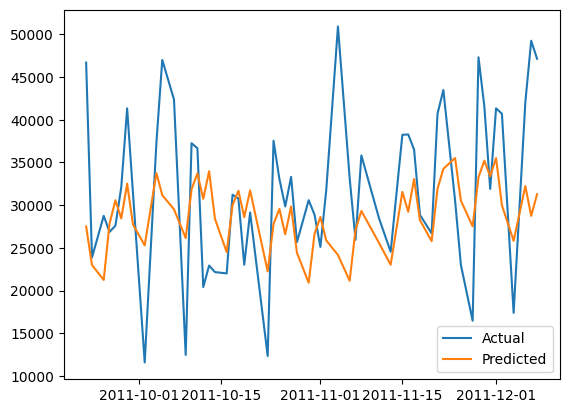

MAPE:  0.24606731875486473


In [16]:
m = Prophet(growth='linear', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative',
            changepoint_prior_scale=best_param['change_prior_scale'], seasonality_prior_scale=best_param['seasonality_prior_scale'], holidays_prior_scale=best_param['holidays_prior_scale'],
            changepoint_range=best_param['changepoint_range'], interval_width=best_param['interval_width'], uncertainty_samples=best_param['uncertainty_samples']
            )
m.add_country_holidays(country_name='UK')
m.fit(training_x)
future = testing_x[['ds']]
forecast = m.predict(future)
plt.plot(testing_x['ds'], testing_x['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted')
plt.legend()
plt.show()
print("MAPE: ", mean_absolute_percentage_error(testing_x['y'], forecast['yhat']))

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebre

MAPE test1:  0.31171011552928024
MAPE test2:  0.19813150827351006
MAPE test3:  0.22924568177645693


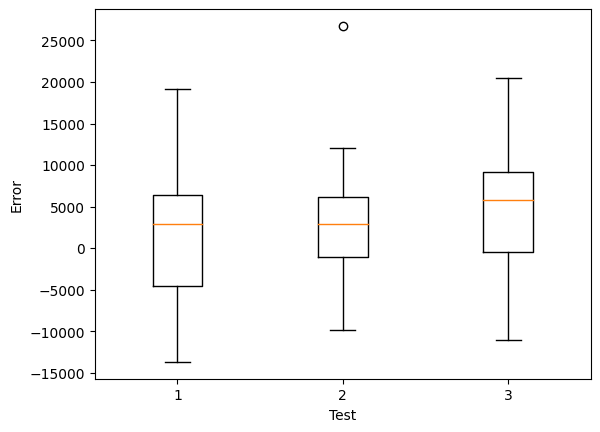

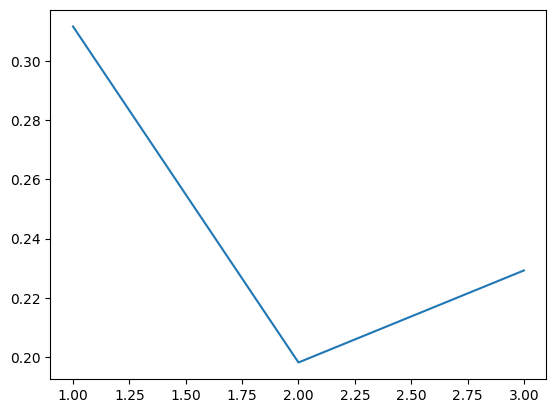

In [17]:
# split testing data into three parts
test1 = testing_x.iloc[:int(len(testing_x)/3)].reset_index(drop=True)
test2 = testing_x.iloc[int(len(testing_x)/3):int(len(testing_x)*2/3)].reset_index(drop=True)
test3 = testing_x.iloc[int(len(testing_x)*2/3):].reset_index(drop=True)
mape_test = []
err = pd.DataFrame(columns=['test1','test2','test3'])
forecast1 = m.predict(test1[['ds']])
err['test1'] = test1['y'] - forecast1['yhat']
mape_test.append(mean_absolute_percentage_error(test1['y'], forecast1['yhat']))
print("MAPE test1: ", mean_absolute_percentage_error(test1['y'], forecast1['yhat']))

forecast2 = m.predict(test2[['ds']])
err['test2'] = test2['y'] - forecast2['yhat']
mape_test.append(mean_absolute_percentage_error(test2['y'], forecast2['yhat']))
print("MAPE test2: ", mean_absolute_percentage_error(test2['y'], forecast2['yhat']))

forecast3 = m.predict(test3[['ds']])
err['test3'] = test3['y'] - forecast3['yhat']
mape_test.append(mean_absolute_percentage_error(test3['y'], forecast3['yhat']))
print("MAPE test3: ", mean_absolute_percentage_error(test3['y'], forecast3['yhat']))

plt.boxplot(err)
plt.xlabel('Test')
plt.ylabel('Error')
plt.show()

plt.plot([1,2,3],mape_test)